In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# imports:
### Inspired from - https://www.kaggle.com/code/bryamblasrimac/classification-eda-smote-voting-accuracy-82-07#6.-Models
## Data handling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno # missing values visualization

## Stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import norm

## Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

## Classes Imbalance
from imblearn.over_sampling import SMOTE

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


## Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Time
import time

## Warnings
import warnings
warnings.filterwarnings('ignore')

# some more imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sleepy-driver-eeg-brainwave-data/acquiredDataset.csv


In [3]:
df=pd.read_csv('/kaggle/input/sleepy-driver-eeg-brainwave-data/acquiredDataset.csv')
df.head(2)

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0


In [90]:
df['classification'].value_counts()

classification
0    2135
1    1600
Name: count, dtype: int64

# Apply smote


In [7]:
#learning curves

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 20)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation Accuracy")
    
    plt.legend(loc="best")
    plt.show()


In [4]:
df.rename(columns = {'classification':'sleepiness'}, inplace = True)
df.head(1)

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,sleepiness
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0


In [8]:
X=df.drop('sleepiness',axis=1)
y=df['sleepiness']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)

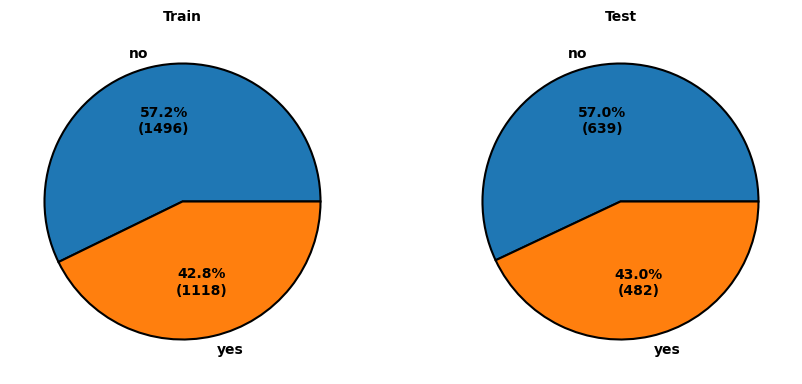

In [14]:
# Visualization of the objective variable in the training and test set.
df_pct_train = y_train.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_train = df_pct_train.rename(columns = {'y':'count'})

labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:,0]

df_pct_test = y_test.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_test = df_pct_test.rename(columns = {'y':'count'})

labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:,0]


fig,axes = plt.subplots(1,2,figsize = (9,4))

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


axes[0].pie(x = values_train, labels = labels_train, autopct = autopct_fun(values_train),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[0].set_title('Train', fontsize = 10, fontweight = 'bold', color = 'black')

axes[1].pie(x = values_test, labels = labels_test, autopct = autopct_fun(values_test),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[1].set_title('Test', fontsize = 10, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [9]:
# Oversampling 
smote = SMOTE(random_state = 1)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

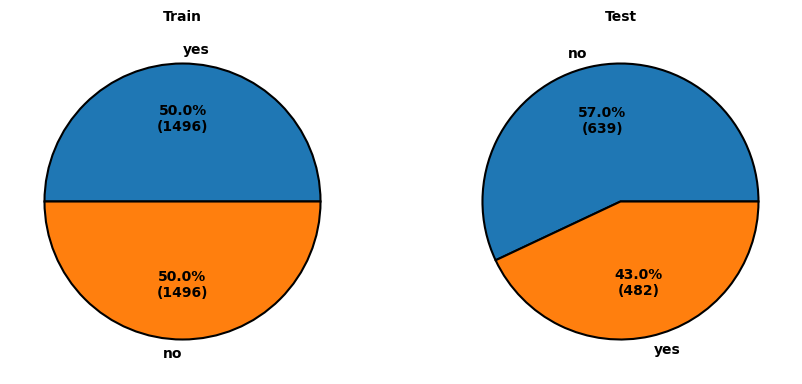

In [10]:
# Visualization of the objective variable in the training and test set.
df_pct_train = y_train_smote.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_train = df_pct_train.rename(columns = {'y':'count'})

labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:,0]

df_pct_test = y_test.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_test = df_pct_test.rename(columns = {'y':'count'})

labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:,0]


fig,axes = plt.subplots(1,2,figsize = (9,4))

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


axes[0].pie(x = values_train, labels = labels_train, autopct = autopct_fun(values_train),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[0].set_title('Train', fontsize = 10, fontweight = 'bold', color = 'black')

axes[1].pie(x = values_test, labels = labels_test, autopct = autopct_fun(values_test),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[1].set_title('Test', fontsize = 10, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

# Models

In [97]:
SEED=30

In [98]:
# Estimators for the VotingClassifier and StackingClassifier.
e1 = XGBClassifier(objective = 'binary:logistic', random_state = SEED,
                   tree_method = "exact", booster = 'gbtree')
e2 = LGBMClassifier(random_state = SEED, verbose = -1)
e3 = CatBoostClassifier(random_state = SEED, verbose = 0)

voting1 = VotingClassifier(estimators = [('lgbm', e2), ('cb', e3)])

In [99]:
# We define the models to use.
lr = LogisticRegression(random_state = SEED)

rf = RandomForestClassifier(random_state = SEED)

et = ExtraTreesClassifier(bootstrap = True, random_state = SEED)

svc = SVC(random_state = SEED)

knn = KNeighborsClassifier()

hgb = HistGradientBoostingClassifier(random_state = SEED)

xgb = XGBClassifier(objective = 'binary:logistic', tree_method = "exact",
                    random_state = SEED, booster = 'gbtree')

lgbm = LGBMClassifier(random_state = SEED, verbose = -1)

cb = CatBoostClassifier(random_state = SEED, verbose = 0)

voting = VotingClassifier(estimators = [('lgbm', e2), ('cb', e3)])

stacking = StackingClassifier(estimators = [('lgbm', e2), ('cb', e3)],
                              final_estimator = voting1, stack_method='predict')

# We create a dictionary where we store our models with their respective names.
base_models = {'Logistic_Regression':lr,
               'Random_Forest':rf,
               'Extra_Trees':et,
               'SVC':svc,
               'KNN':knn,
               'XGB':xgb,
               'LGBM':lgbm,
               'CatBoost':cb,
               'Voting':voting,
               'Stacking':stacking,
               'HistGrad':hgb}

In [100]:
# without smote 
## Training

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

for model_name, model in base_models.items():
  start = time.time()
  model.fit(X_train, y_train)
  end = time.time()
  print(f'* {model_name}: {end-start} seconds')
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  accuracy_train[model_name] = accuracy_score(np.array(y_train), y_pred_train)
  accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
  confusion_matrix_train[model_name] = confusion_matrix(np.array(y_train), y_pred_train)
  confusion_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)

# We create a dataframe showing the accuracy results in training and testing.
df_accuracy_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'Train'})
df_accuracy_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'Test'})
df_accuracy = pd.merge(df_accuracy_train, df_accuracy_test, left_index = True, right_index = True)
df_accuracy = df_accuracy.sort_values(['Train', 'Test'], ascending = False)
df_accuracy

* Logistic_Regression: 0.08469462394714355 seconds
* Random_Forest: 1.0005114078521729 seconds
* Extra_Trees: 0.4490058422088623 seconds
* SVC: 0.2707540988922119 seconds
* KNN: 0.005481243133544922 seconds
* XGB: 0.625953197479248 seconds
* LGBM: 0.7002246379852295 seconds
* CatBoost: 3.363633394241333 seconds
* Voting: 4.076046466827393 seconds
* Stacking: 25.223516941070557 seconds
* HistGrad: 0.5182468891143799 seconds


,Train,Test
Random_Forest,1.000000,0.789474
Extra_Trees,1.000000,0.773417
XGB,0.999617,0.798394
HistGrad,0.988906,0.807315
LGBM,0.987376,0.802855
Voting,0.957536,0.809099
CatBoost,0.942234,0.814451
Stacking,0.942234,0.814451
KNN,0.807192,0.705620
SVC,0.691278,0.673506


In [101]:
# with smote
## Training

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

for model_name, model in base_models.items():
  start = time.time()
  model.fit(X_train_smote, y_train_smote)
  end = time.time()
  print(f'* {model_name}: {end-start} seconds')
  y_pred_train = model.predict(X_train_smote)
  y_pred_test = model.predict(X_test)
  accuracy_train[model_name] = accuracy_score(np.array(y_train_smote), y_pred_train)
  accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
  confusion_matrix_train[model_name] = confusion_matrix(np.array(y_train_smote), y_pred_train)
  confusion_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)
    # We create a dataframe showing the accuracy results in training and testing.
df_accuracy_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'Train'})
df_accuracy_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'Test'})
df_accuracy = pd.merge(df_accuracy_train, df_accuracy_test, left_index = True, right_index = True)
df_accuracy = df_accuracy.sort_values(['Train', 'Test'], ascending = False)
df_accuracy

* Logistic_Regression: 0.0896446704864502 seconds
* Random_Forest: 1.1437373161315918 seconds
* Extra_Trees: 0.47551608085632324 seconds
* SVC: 0.3547532558441162 seconds
* KNN: 0.005873203277587891 seconds
* XGB: 0.7155506610870361 seconds
* LGBM: 0.7600176334381104 seconds
* CatBoost: 3.62646222114563 seconds
* Voting: 4.990371942520142 seconds
* Stacking: 26.193336963653564 seconds
* HistGrad: 0.5643339157104492 seconds


,Train,Test
XGB,1.000000,0.786798
Random_Forest,1.000000,0.772525
Extra_Trees,1.000000,0.763604
HistGrad,0.987299,0.802855
LGBM,0.985628,0.802855
Voting,0.966243,0.808207
Stacking,0.966243,0.808207
CatBoost,0.944853,0.819804
KNN,0.828543,0.702944
SVC,0.692179,0.666369


In [102]:
# # We create a dataframe showing the accuracy results in training and testing.
# df_accuracy_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'Train'})
# df_accuracy_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'Test'})
# df_accuracy = pd.merge(df_accuracy_train, df_accuracy_test, left_index = True, right_index = True)
# df_accuracy = df_accuracy.sort_values(['Train', 'Test'], ascending = False)
# df_accuracy

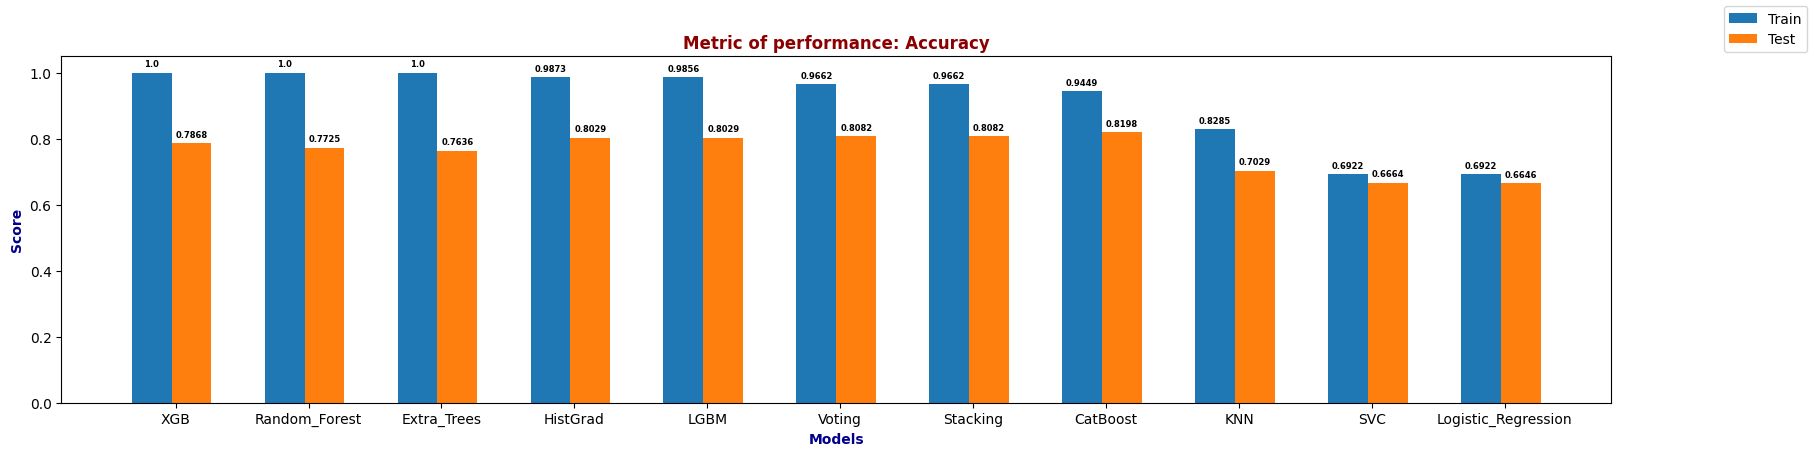

In [103]:
# Let's visualize the metric in a bar graph.
fig,ax = plt.subplots(figsize = (20, 4.5))
n = len(df_accuracy.index)
x = np.arange(n)
width = 0.3

rects1 = ax.bar(x = x-width, height = df_accuracy.iloc[:,0], width = width)
rects2 = ax.bar(x = x, height = df_accuracy.iloc[:,1], width = width)
ax.set_xticks(x-0.12, df_accuracy.index.to_list())
ax.set_xlabel('Models', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Metric of performance: Accuracy', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{round(height,4)}',
                xy = (rect.get_x()+rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 6,
                weight = 'bold',
                color = 'black')

autolabel(rects1)
autolabel(rects2)
fig.legend(["Train", "Test"])
fig.show()


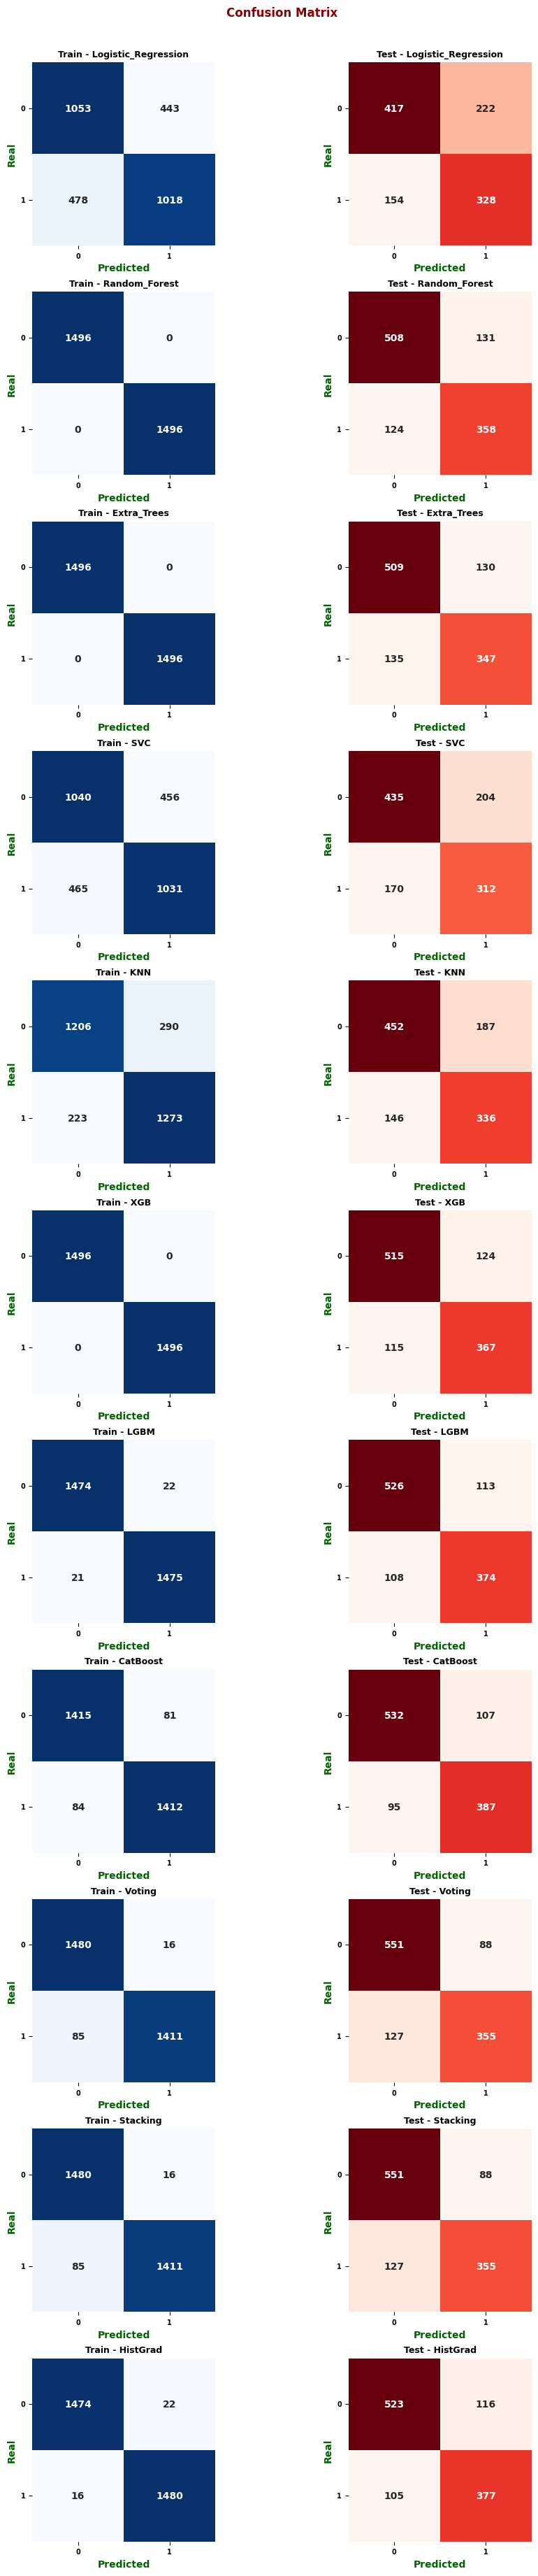

In [104]:
# Now let's visualize the confusion matrix that was generated from each model in training and testing.
fig,ax = plt.subplots(nrows = 11, ncols = 2, figsize = (10, 40))

for p, ((model_name_train,cmx_train), (model_name_test, cmx_test)) in enumerate(zip(confusion_matrix_train.items(), confusion_matrix_test.items())):

  sns.heatmap(cmx_train, annot = True, square = True, cmap = 'Blues', fmt = '',annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,0])
  ax[p,0].set_title(f'Train - {model_name_train}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,0].tick_params('y', rotation = 0)
  ax[p,0].set_xticklabels(ax[p,0].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_yticklabels(ax[p,0].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,0].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')

  sns.heatmap(cmx_test, annot = True, square = True, cmap = 'Reds', fmt = '', annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,1])
  ax[p,1].set_title(f'Test - {model_name_test}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,1].tick_params('y', rotation = 0)
  ax[p,1].set_xticklabels(ax[p,1].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_yticklabels(ax[p,1].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,1].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')


fig.suptitle('Confusion Matrix', fontsize = 12, fontweight = 'bold', color = 'darkred', y = 0.92)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [105]:
# lets try my xgb method here:
# X=X.drop('user-definedlabeln',axis=1)
# y=one_hot_encoded_data['user-definedlabeln']
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)


gbm_param_grid = {
    'n_estimators': range(10, 100,10),
    'max_depth': range(3, 5),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}
gbm = XGBClassifier(n_estimators=100)
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 5)
xgb_random.fit(X, y)
rfc3=xgb_random.predict(X_test)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_,end="\n\n")
print("Best accuracy found: ", xgb_random.best_score_,end="\n\n")

print("accuracy=",accuracy_score(y_test,rfc3),end="\n\n")
print("confusion matrix:\n\n",classification_report(y_test,rfc3,digits=5))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.4, 'colsample_bytree': 0.8}

Best accuracy found:  0.6548862115127175

accuracy= 0.8064228367528992

confusion matrix:

               precision    recall  f1-score   support

           0    0.80316   0.87480   0.83745       639
           1    0.81176   0.71577   0.76075       482

    accuracy                        0.80642      1121
   macro avg    0.80746   0.79529   0.79910      1121
weighted avg    0.80686   0.80642   0.80447      1121



In [106]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 20)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation Accuracy")
    
    plt.legend(loc="best")
    plt.show()


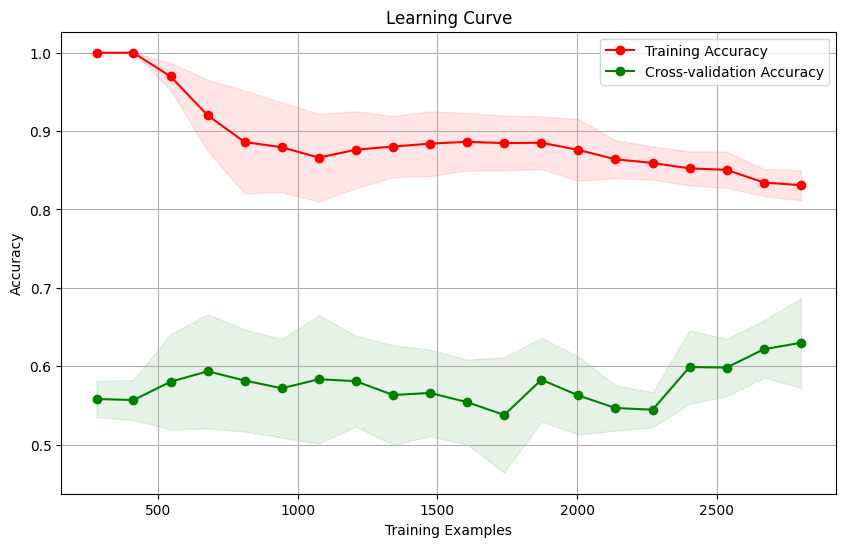

In [107]:
plot_learning_curve(xgb_random.best_estimator_, X, y, cv=4)

# With Normalisation:


In [108]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on your data and transform the features
X_normalised = scaler.fit_transform(X)

# Note: You can also apply the same transformation to your testing data if needed
# X_test_normalized = scaler.transform(X_test)

X_train, X_test, y_train, y_test = train_test_split(X_normalised, y, test_size=0.2, random_state=42)

In [109]:
## Training

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

for model_name, model in base_models.items():
  start = time.time()
  model.fit(X_train_smote, y_train_smote)
  end = time.time()
  print(f'* {model_name}: {end-start} seconds')
  y_pred_train = model.predict(X_train_smote)
  y_pred_test = model.predict(X_test)
  accuracy_train[model_name] = accuracy_score(np.array(y_train_smote), y_pred_train)
  accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
  confusion_matrix_train[model_name] = confusion_matrix(np.array(y_train_smote), y_pred_train)
  confusion_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)


* Logistic_Regression: 0.08873772621154785 seconds
* Random_Forest: 1.1269187927246094 seconds
* Extra_Trees: 0.4709584712982178 seconds
* SVC: 0.35863804817199707 seconds
* KNN: 0.005980491638183594 seconds
* XGB: 0.7193868160247803 seconds
* LGBM: 0.6959445476531982 seconds
* CatBoost: 3.528148889541626 seconds
* Voting: 4.409661769866943 seconds
* Stacking: 26.12770414352417 seconds
* HistGrad: 0.5132737159729004 seconds


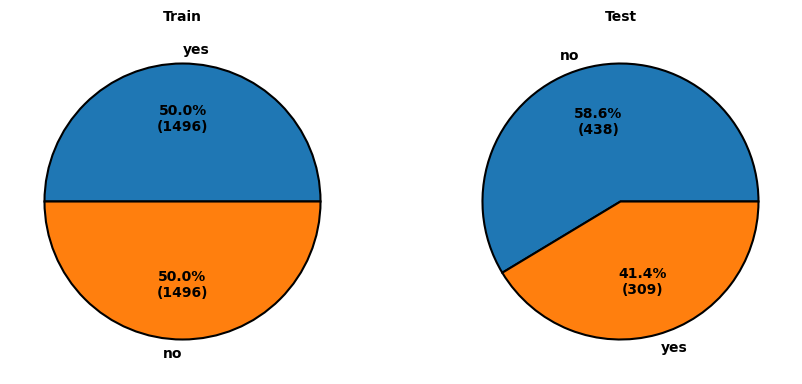

In [110]:
# Visualization of the objective variable in the training and test set.
df_pct_train = y_train_smote.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_train = df_pct_train.rename(columns = {'y':'count'})

labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:,0]

df_pct_test = y_test.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_test = df_pct_test.rename(columns = {'y':'count'})

labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:,0]


fig,axes = plt.subplots(1,2,figsize = (9,4))

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


axes[0].pie(x = values_train, labels = labels_train, autopct = autopct_fun(values_train),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[0].set_title('Train', fontsize = 10, fontweight = 'bold', color = 'black')

axes[1].pie(x = values_test, labels = labels_test, autopct = autopct_fun(values_test),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[1].set_title('Test', fontsize = 10, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [111]:
# We create a dataframe showing the accuracy results in training and testing.
df_accuracy_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'Train'})
df_accuracy_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'Test'})
df_accuracy = pd.merge(df_accuracy_train, df_accuracy_test, left_index = True, right_index = True)
df_accuracy = df_accuracy.sort_values(['Train', 'Test'], ascending = False)
df_accuracy

,Train,Test
Random_Forest,1.000000,0.586345
XGB,1.000000,0.586345
Extra_Trees,1.000000,0.413655
HistGrad,0.987299,0.586345
LGBM,0.985628,0.586345
Voting,0.966243,0.586345
Stacking,0.966243,0.586345
CatBoost,0.944853,0.413655
KNN,0.828543,0.586345
Logistic_Regression,0.692179,0.413655


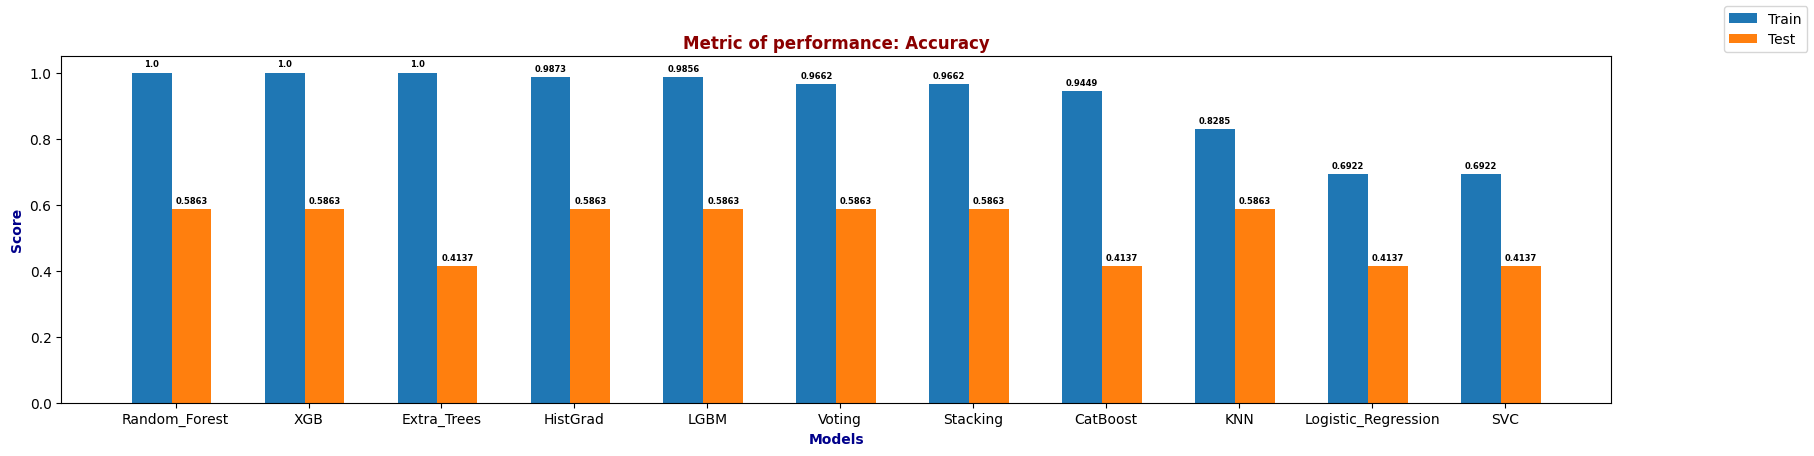

In [112]:
# Let's visualize the metric in a bar graph.
fig,ax = plt.subplots(figsize = (20, 4.5))
n = len(df_accuracy.index)
x = np.arange(n)
width = 0.3

rects1 = ax.bar(x = x-width, height = df_accuracy.iloc[:,0], width = width)
rects2 = ax.bar(x = x, height = df_accuracy.iloc[:,1], width = width)
ax.set_xticks(x-0.12, df_accuracy.index.to_list())
ax.set_xlabel('Models', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Metric of performance: Accuracy', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{round(height,4)}',
                xy = (rect.get_x()+rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 6,
                weight = 'bold',
                color = 'black')

autolabel(rects1)
autolabel(rects2)
fig.legend(["Train", "Test"])
fig.show()

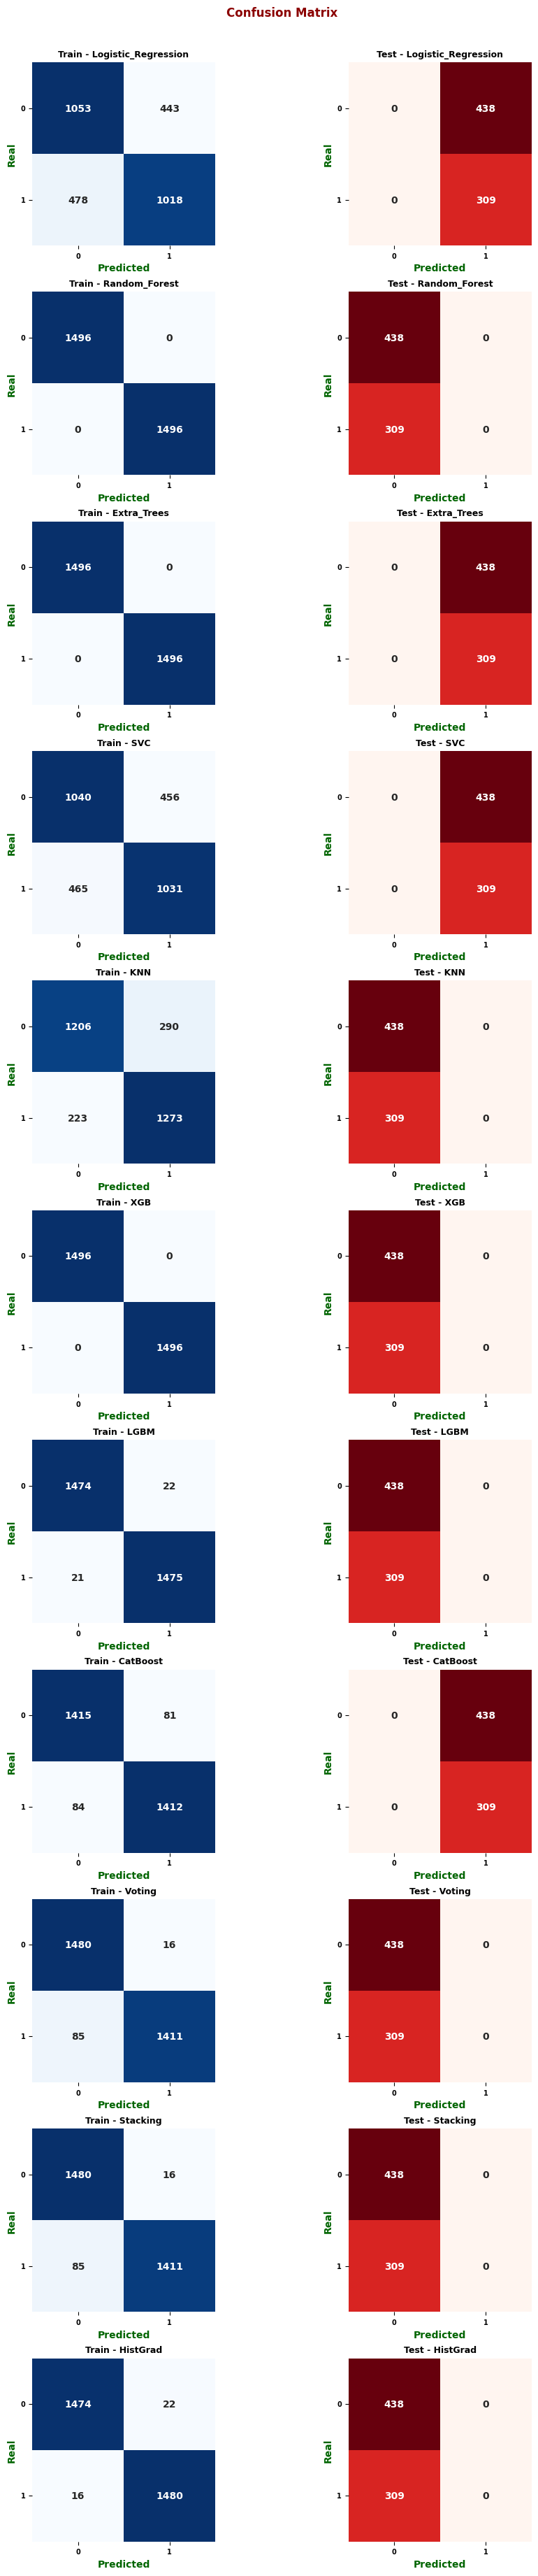

In [113]:
# Now let's visualize the confusion matrix that was generated from each model in training and testing.
fig,ax = plt.subplots(nrows = 11, ncols = 2, figsize = (10, 40))

for p, ((model_name_train,cmx_train), (model_name_test, cmx_test)) in enumerate(zip(confusion_matrix_train.items(), confusion_matrix_test.items())):

  sns.heatmap(cmx_train, annot = True, square = True, cmap = 'Blues', fmt = '',annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,0])
  ax[p,0].set_title(f'Train - {model_name_train}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,0].tick_params('y', rotation = 0)
  ax[p,0].set_xticklabels(ax[p,0].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_yticklabels(ax[p,0].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,0].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')

  sns.heatmap(cmx_test, annot = True, square = True, cmap = 'Reds', fmt = '', annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,1])
  ax[p,1].set_title(f'Test - {model_name_test}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,1].tick_params('y', rotation = 0)
  ax[p,1].set_xticklabels(ax[p,1].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_yticklabels(ax[p,1].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,1].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')


fig.suptitle('Confusion Matrix', fontsize = 12, fontweight = 'bold', color = 'darkred', y = 0.92)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [114]:
temp=pd.DataFrame(X_train,columns=X.columns)
temp.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma
0,0.373737,0.595960,0.261616,0.010651,0.016813,0.031243,0.019783,0.018215,0.039685,0.002215
1,0.292929,0.535354,0.021255,0.045238,0.011010,0.023405,0.012973,0.032445,0.027894,0.003645
2,0.909091,0.252525,0.265825,0.350430,0.384757,0.166297,0.451629,0.437976,0.408065,0.011865
3,0.434343,0.474747,0.269451,0.063925,0.021403,0.023555,0.025170,0.014953,0.026328,0.300125
4,0.737374,0.808081,0.000000,0.006948,0.044552,0.033554,0.052340,0.032007,0.026038,0.062934


# Normalisation with smote gave bad results hence we will try to avoid it

In [124]:
X=df.drop('sleepiness',axis=1)
y=df['sleepiness']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)
cols_to_plot=X.columns
cols_to_plot

Index(['attention', 'meditation', 'delta', 'theta', 'lowAlpha', 'highAlpha',
       'lowBeta', 'highBeta', 'lowGamma', 'highGamma'],
      dtype='object')

Graph without normalisation

      attention  meditation   delta    theta  lowAlpha  highAlpha  lowBeta  \
3570         38          60  941649    34161     11784      24564    11784   
3729         30          54   76703   144637      7728      18404     7728   
258          91          26  956793  1119489    268968     130708   268968   
2037         44          48  969841   204328     14992      18522    14992   
2387         74          81     216    22332     31173      26380    31173   
...         ...         ...     ...      ...       ...        ...      ...   
1130         11          81  230886    66599     13030       9047     4008   
1294          1          90  306050    74312      4022       5187     8418   
860          51          40  871083    88828     45395      19388    45395   
3507         43          48  774265    86342     22254      65750    22254   
3174         88          37  372332   147255     50124      45668    50124   

      highBeta  lowGamma  highGamma  
3570      8083     11486 

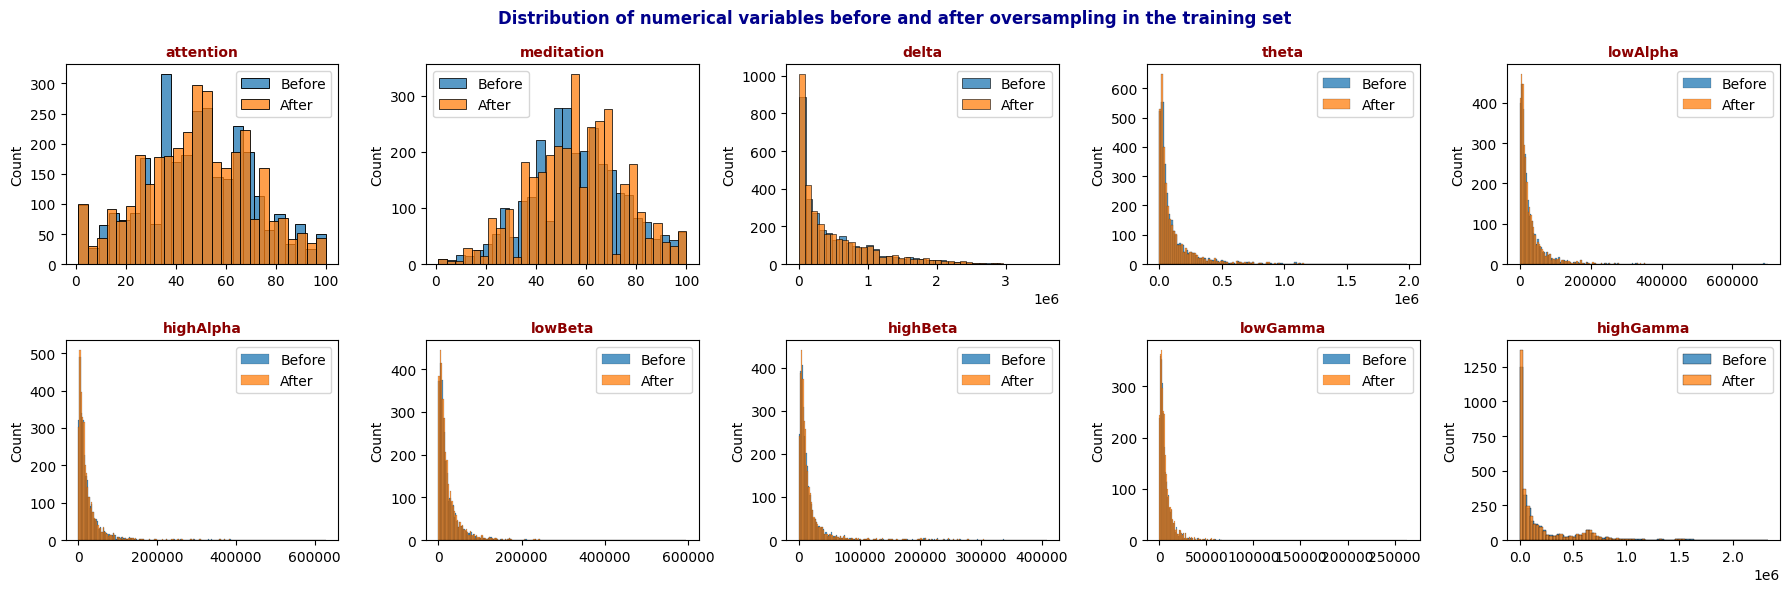

In [125]:
# Oversampling


smote = SMOTE(random_state=SEED)
# X_normalised = scaler.fit_transform(X)
# X_normalised2 = pd.DataFrame(X_normalised, columns=cols_to_plot)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train2)
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train2, y_train2)

fig, ax = plt.subplots(2, 5, figsize=(18, 6))
# print(X_train)
# print("attention",X_train["attention"])
for i, col in enumerate(cols_to_plot):
    
    row = i // 5
    col_num = i % 5
    sns.histplot(X_train2[col], ax=ax[row, col_num], label="Before")
    sns.histplot(X_train_smote2[col], ax=ax[row, col_num], label="After")
    ax[row, col_num].set_xlabel('')
    ax[row, col_num].set_title(f'{col}', fontsize=10, fontweight='bold', color='darkred')
    ax[row, col_num].legend()

fig.suptitle('Distribution of numerical variables before and after oversampling in the training set', fontsize=12, fontweight='bold', color='darkblue')
fig.tight_layout()
fig.show()


Graph with normalisation:

      attention  meditation     delta     theta  lowAlpha  highAlpha  \
3570   0.373737    0.595960  0.261616  0.010651  0.016813   0.031243   
3729   0.292929    0.535354  0.021255  0.045238  0.011010   0.023405   
258    0.909091    0.252525  0.265825  0.350430  0.384757   0.166297   
2037   0.434343    0.474747  0.269451  0.063925  0.021403   0.023555   
2387   0.737374    0.808081  0.000000  0.006948  0.044552   0.033554   
...         ...         ...       ...       ...       ...        ...   
1130   0.101010    0.808081  0.064101  0.020807  0.018596   0.011500   
1294   0.000000    0.898990  0.084989  0.023221  0.005708   0.006588   
860    0.505051    0.393939  0.242007  0.027766  0.064899   0.024657   
3507   0.424242    0.474747  0.215102  0.026987  0.031792   0.083647   
3174   0.878788    0.363636  0.103408  0.046057  0.071665   0.058095   

       lowBeta  highBeta  lowGamma  highGamma  
3570  0.019783  0.018215  0.039685   0.002215  
3729  0.012973  0.032445  0.027894   0.

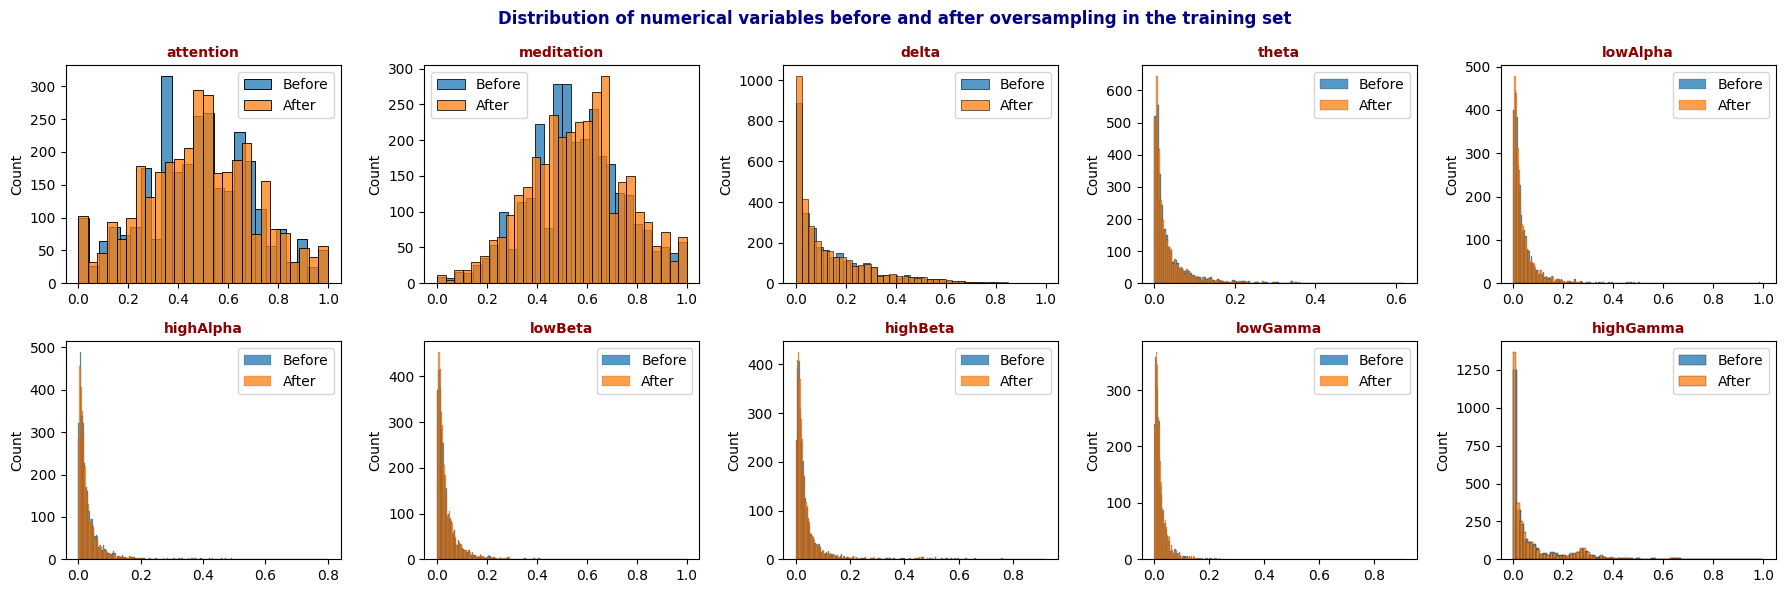

In [126]:
# Oversampling
smote = SMOTE(random_state=SEED)
X_normalised = scaler.fit_transform(X)
X_normalised2 = pd.DataFrame(X_normalised, columns=cols_to_plot)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_normalised2, y, test_size=0.2, random_state=42)
print(X_train2)
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train2, y_train2)

fig, ax = plt.subplots(2, 5, figsize=(18, 6))
# print(X_train)
# print("attention",X_train["attention"])
for i, col in enumerate(cols_to_plot):
    
    row = i // 5
    col_num = i % 5
    sns.histplot(X_train2[col], ax=ax[row, col_num], label="Before")
    sns.histplot(X_train_smote2[col], ax=ax[row, col_num], label="After")
    ax[row, col_num].set_xlabel('')
    ax[row, col_num].set_title(f'{col}', fontsize=10, fontweight='bold', color='darkred')
    ax[row, col_num].legend()

fig.suptitle('Distribution of numerical variables before and after oversampling in the training set', fontsize=12, fontweight='bold', color='darkblue')
fig.tight_layout()
fig.show()


Saving xgb model

In [118]:
import pickle

# Assuming you have trained an XGBoost model and saved it in a variable called 'xgb_model'
# Serialize and save the model to a file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_random, file)


In [119]:
import pickle

# Assuming you have trained an XGBoost model and saved it in a variable called 'xgb_model'
# Serialize and save the model to a file
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(cb, file)


# Catboost with smote and no normalisation


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'subsample': 0.9, 'l2_leaf_reg': 5, 'depth': 8}
0:	learn: 0.6582637	total: 7.8ms	remaining: 3.89s
2:	learn: 0.6095127	total: 19.3ms	remaining: 3.19s
4:	learn: 0.5706810	total: 30.6ms	remaining: 3.03s
6:	learn: 0.5442717	total: 42ms	remaining: 2.96s
8:	learn: 0.5211440	total: 52.9ms	remaining: 2.89s
10:	learn: 0.5029853	total: 63.9ms	remaining: 2.84s
12:	learn: 0.4843550	total: 74.8ms	remaining: 2.8s
14:	learn: 0.4714777	total: 86.9ms	remaining: 2.81s
16:	learn: 0.4577020	total: 97.9ms	remaining: 2.78s
18:	learn: 0.4439739	total: 110ms	remaining: 2.79s
20:	learn: 0.4329404	total: 126ms	remaining: 2.87s
22:	learn: 0.4270503	total: 140ms	remaining: 2.9s
24:	learn: 0.4178504	total: 157ms	remaining: 2.99s
26:	learn: 0.4091797	total: 174ms	remaining: 3.05s
28:	learn: 0.3999970	total: 190ms	remaining: 3.09s
30:	learn: 0.3903183	total: 204ms	remaining: 3.09s
32:	learn: 0.3843735	total: 221ms	remaining: 3.13s
34

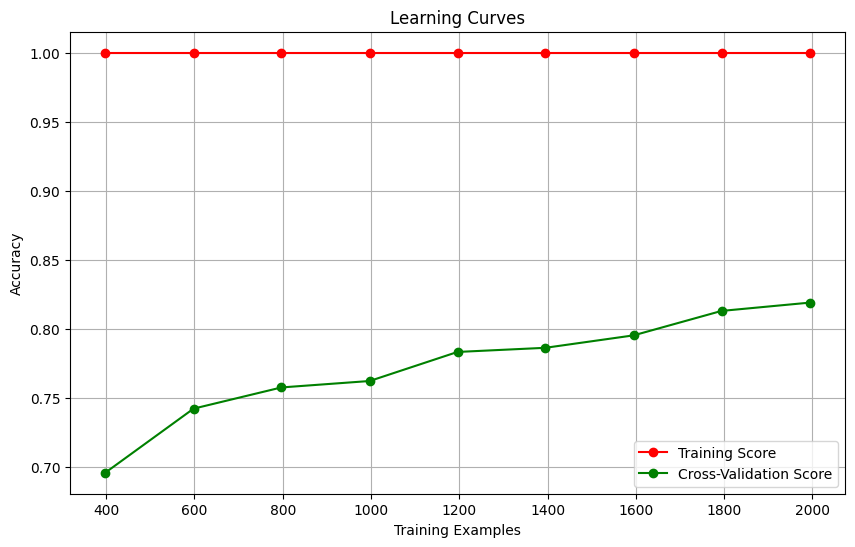

In [55]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Load your dataset (replace 'X' and 'y' with your data)
# X = ...
# y = ...

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoostClassifier
clf = CatBoostClassifier(learning_rate=0.1, iterations=500, random_seed=42, verbose=0)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'depth': [4,6, 8],
    'l2_leaf_reg': [3, 5,10],
    'subsample': [0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV with accuracy scoring
grid_search = RandomizedSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to your data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a CatBoost model with the best hyperparameters
best_clf = CatBoostClassifier(
    learning_rate=0.1,
    iterations=500,
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    subsample=best_params['subsample'],
    random_seed=42,
    verbose=2
)

best_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", accuracy)

# Plot learning curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves for the best model
plot_learning_curves(best_clf, X_train_smote, y_train_smote)


In [56]:
grid_search.cv_results_

{'mean_fit_time': array([ 4.58852824,  6.88102126, 13.94340197, 15.17151721,  5.30051875,
         4.34200978,  3.90221357,  5.87747335, 13.57587147,  8.30105742]),
 'std_fit_time': array([0.07202139, 0.39668112, 0.36427049, 1.06931232, 0.23206458,
        0.09259422, 0.57336573, 0.43028262, 0.75697917, 2.66767821]),
 'mean_score_time': array([0.02787836, 0.02676789, 0.02796563, 0.03403083, 0.02890571,
        0.03783735, 0.02709866, 0.02128243, 0.01477536, 0.01407544]),
 'std_score_time': array([0.01645388, 0.00129245, 0.00747023, 0.01726608, 0.01038299,
        0.02156495, 0.00774441, 0.01006785, 0.00531471, 0.0103213 ]),
 'param_subsample': masked_array(data=[1.0, 0.8, 0.8, 1.0, 0.9, 1.0, 0.8, 0.9, 0.9, 0.8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_l2_leaf_reg': masked_array(data=[3, 10, 3, 3, 10, 10, 3, 5, 5, 5],
              mask=[False, False, False,

In [58]:
grid_search.best_score_

0.8155089852054492

450:	learn: 0.0227434	total: 13.9s	remaining: 1.51s
452:	learn: 0.0225944	total: 14s	remaining: 1.45s
454:	learn: 0.0224327	total: 14.1s	remaining: 1.39s
456:	learn: 0.0222670	total: 14.2s	remaining: 1.33s
458:	learn: 0.0222064	total: 14.2s	remaining: 1.27s
460:	learn: 0.0219838	total: 14.3s	remaining: 1.21s
462:	learn: 0.0217997	total: 14.3s	remaining: 1.14s
464:	learn: 0.0216935	total: 14.4s	remaining: 1.08s
466:	learn: 0.0216156	total: 14.4s	remaining: 1.02s
468:	learn: 0.0215198	total: 14.4s	remaining: 955ms
470:	learn: 0.0213467	total: 14.5s	remaining: 892ms
472:	learn: 0.0212577	total: 14.5s	remaining: 830ms
474:	learn: 0.0211826	total: 14.6s	remaining: 768ms
476:	learn: 0.0210644	total: 14.6s	remaining: 705ms
478:	learn: 0.0210085	total: 14.7s	remaining: 643ms
480:	learn: 0.0208691	total: 14.7s	remaining: 580ms
482:	learn: 0.0207345	total: 14.7s	remaining: 518ms
484:	learn: 0.0205801	total: 14.8s	remaining: 457ms
486:	learn: 0.0204546	total: 14.8s	remaining: 395ms
488:	learn: 0.

In [121]:
df.describe()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,sleepiness
count,3735.000000,3735.000000,3.735000e+03,3.735000e+03,3735.000000,3735.000000,3735.000000,3735.000000,3735.000000,3.735000e+03,3735.00000
mean,48.214726,56.577510,5.187714e+05,1.362420e+05,33413.343775,30580.759036,25640.069076,23276.979384,8117.130388,2.087258e+05,0.42838
std,21.876949,19.066577,5.997837e+05,2.175501e+05,51970.930842,52681.858764,37159.039642,43921.116122,15522.904383,3.297073e+05,0.49491
min,1.000000,1.000000,2.160000e+02,1.380000e+02,32.000000,9.000000,2.000000,3.000000,6.000000,4.700000e+01,0.00000
25%,35.000000,43.000000,7.199650e+04,2.347200e+04,7402.000000,6908.500000,6240.000000,4862.000000,2247.000000,5.683000e+03,0.00000
50%,48.000000,56.000000,2.773820e+05,5.797200e+04,16481.000000,14928.000000,13841.000000,9739.000000,4440.000000,5.719800e+04,0.00000
75%,63.000000,69.000000,7.780680e+05,1.514855e+05,37721.500000,33147.500000,30236.000000,20796.500000,8813.000000,2.576875e+05,1.00000
max,100.000000,100.000000,3.598743e+06,3.194358e+06,699008.000000,785947.000000,595549.000000,443589.000000,289281.000000,2.328370e+06,1.00000


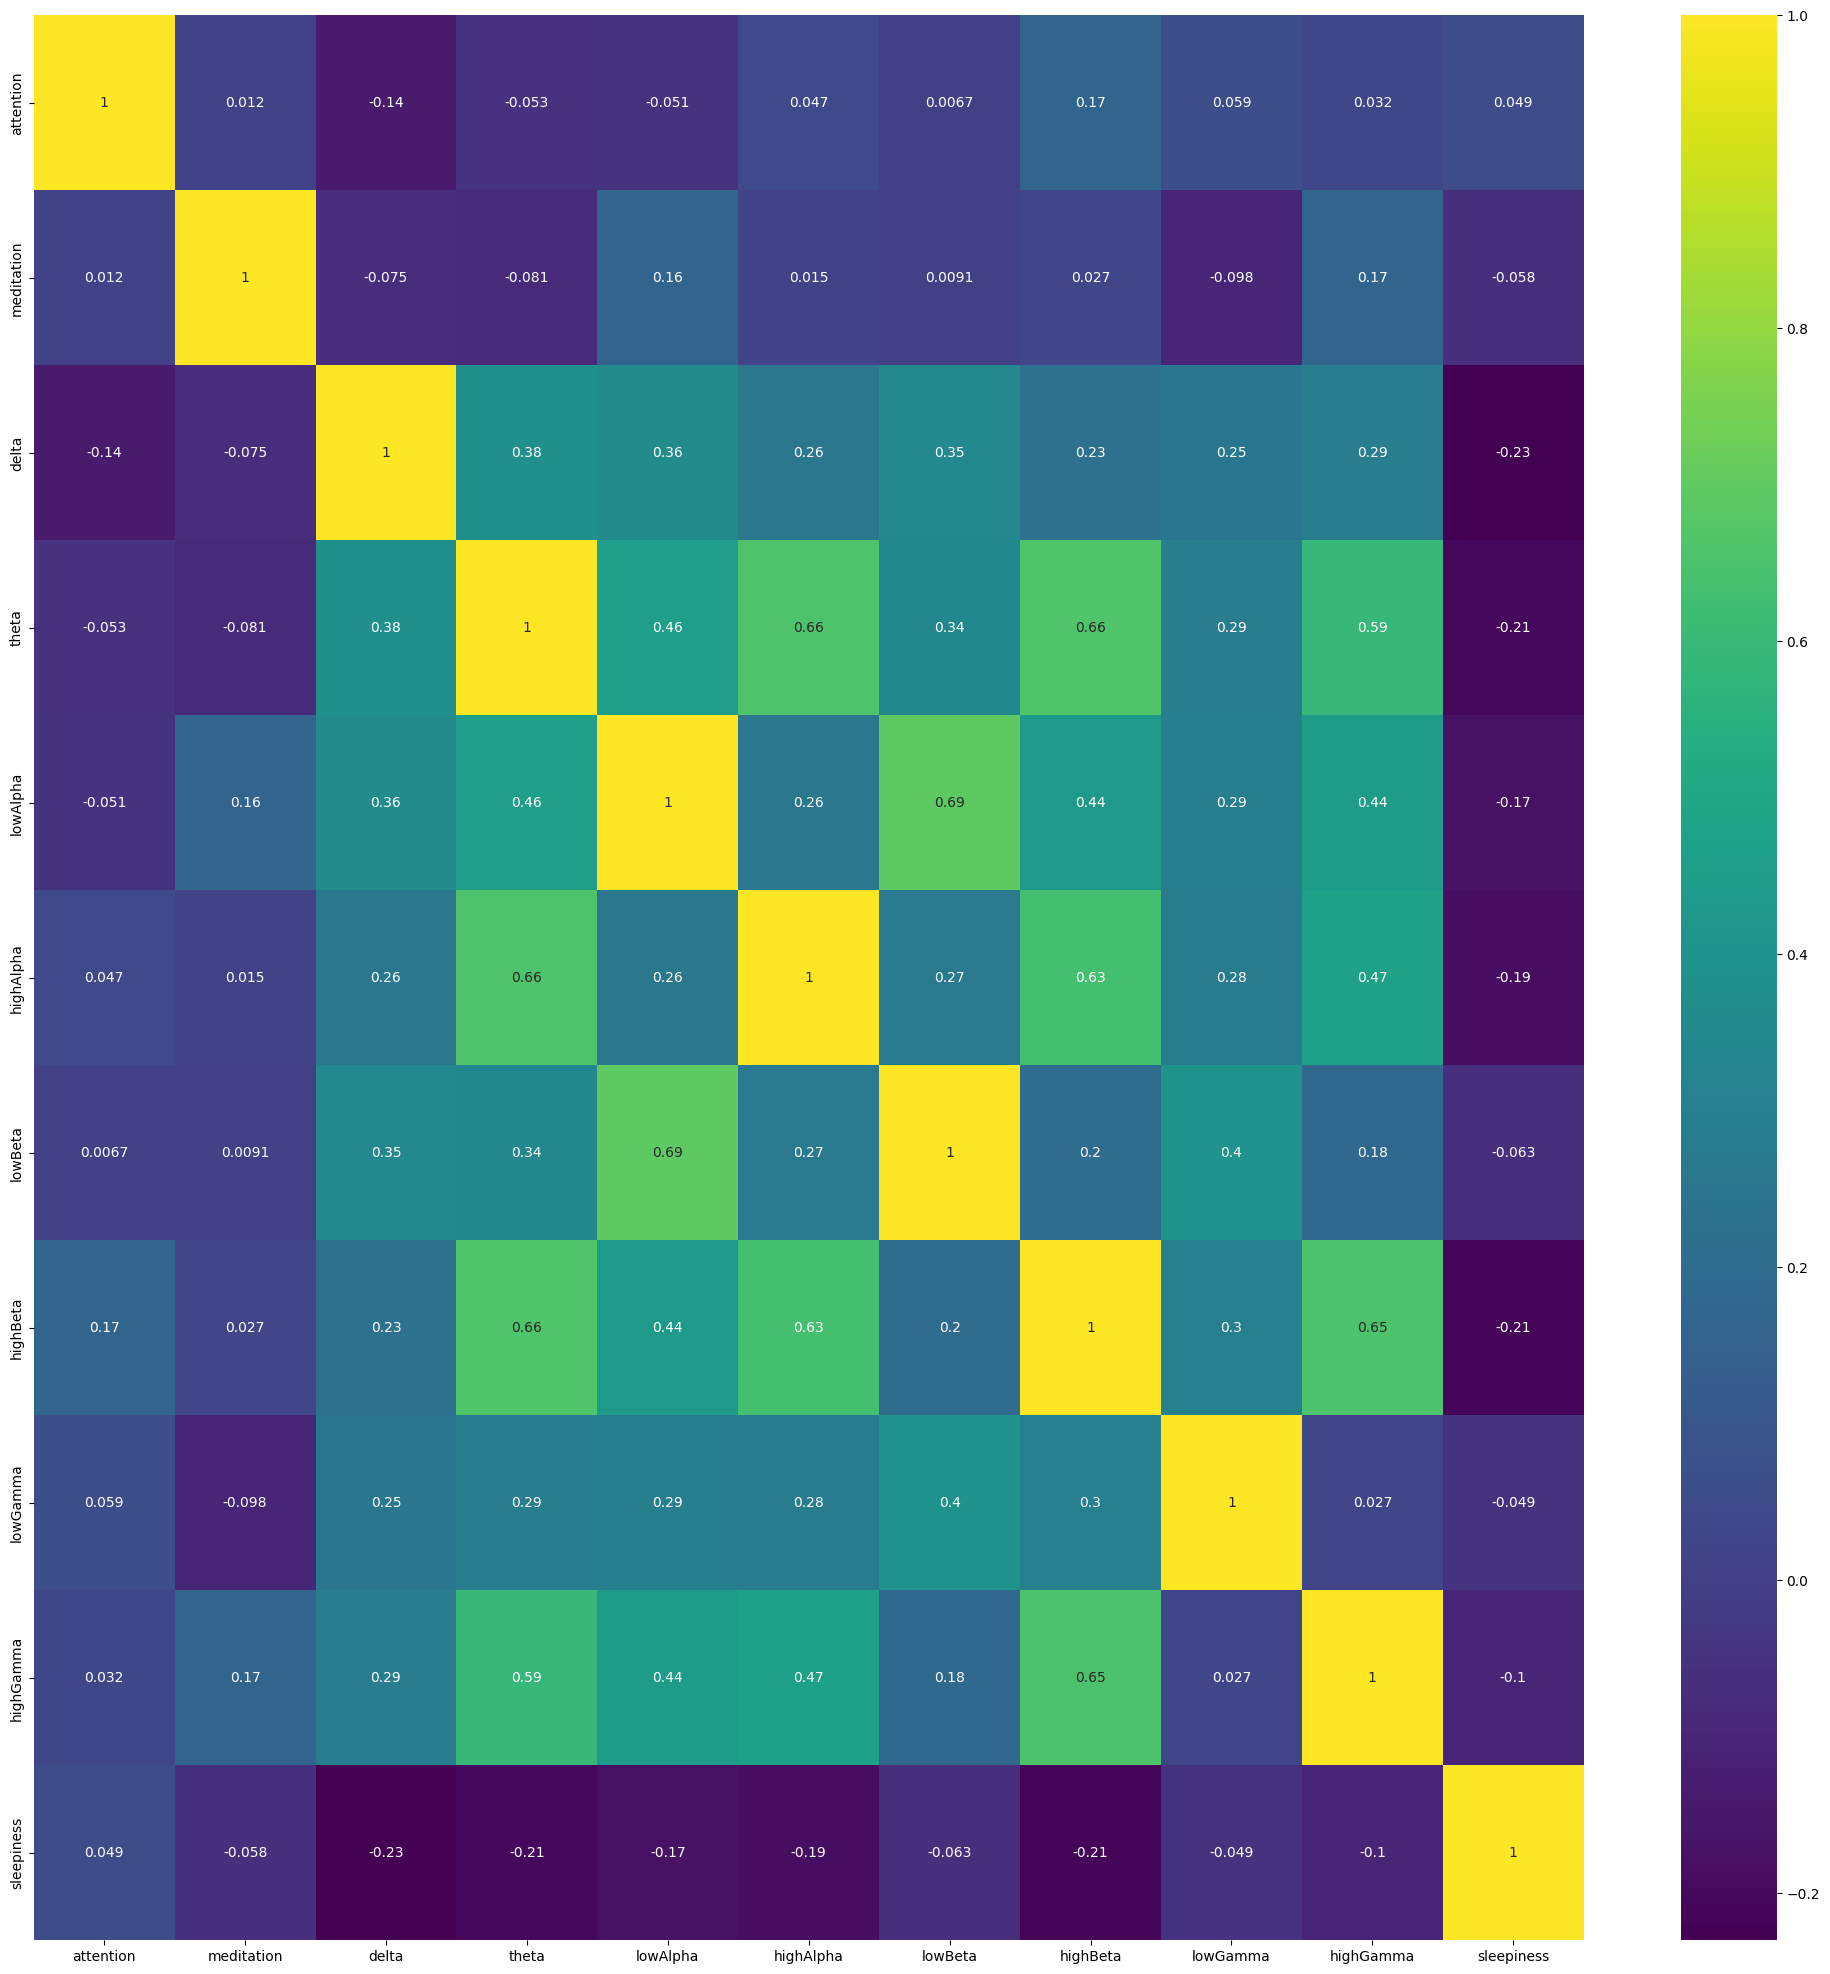

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 25))

sns.heatmap(df.corr(), annot=True,cmap='viridis')

plt.show()

# Violin Plots and Box Plots to see the data distribution

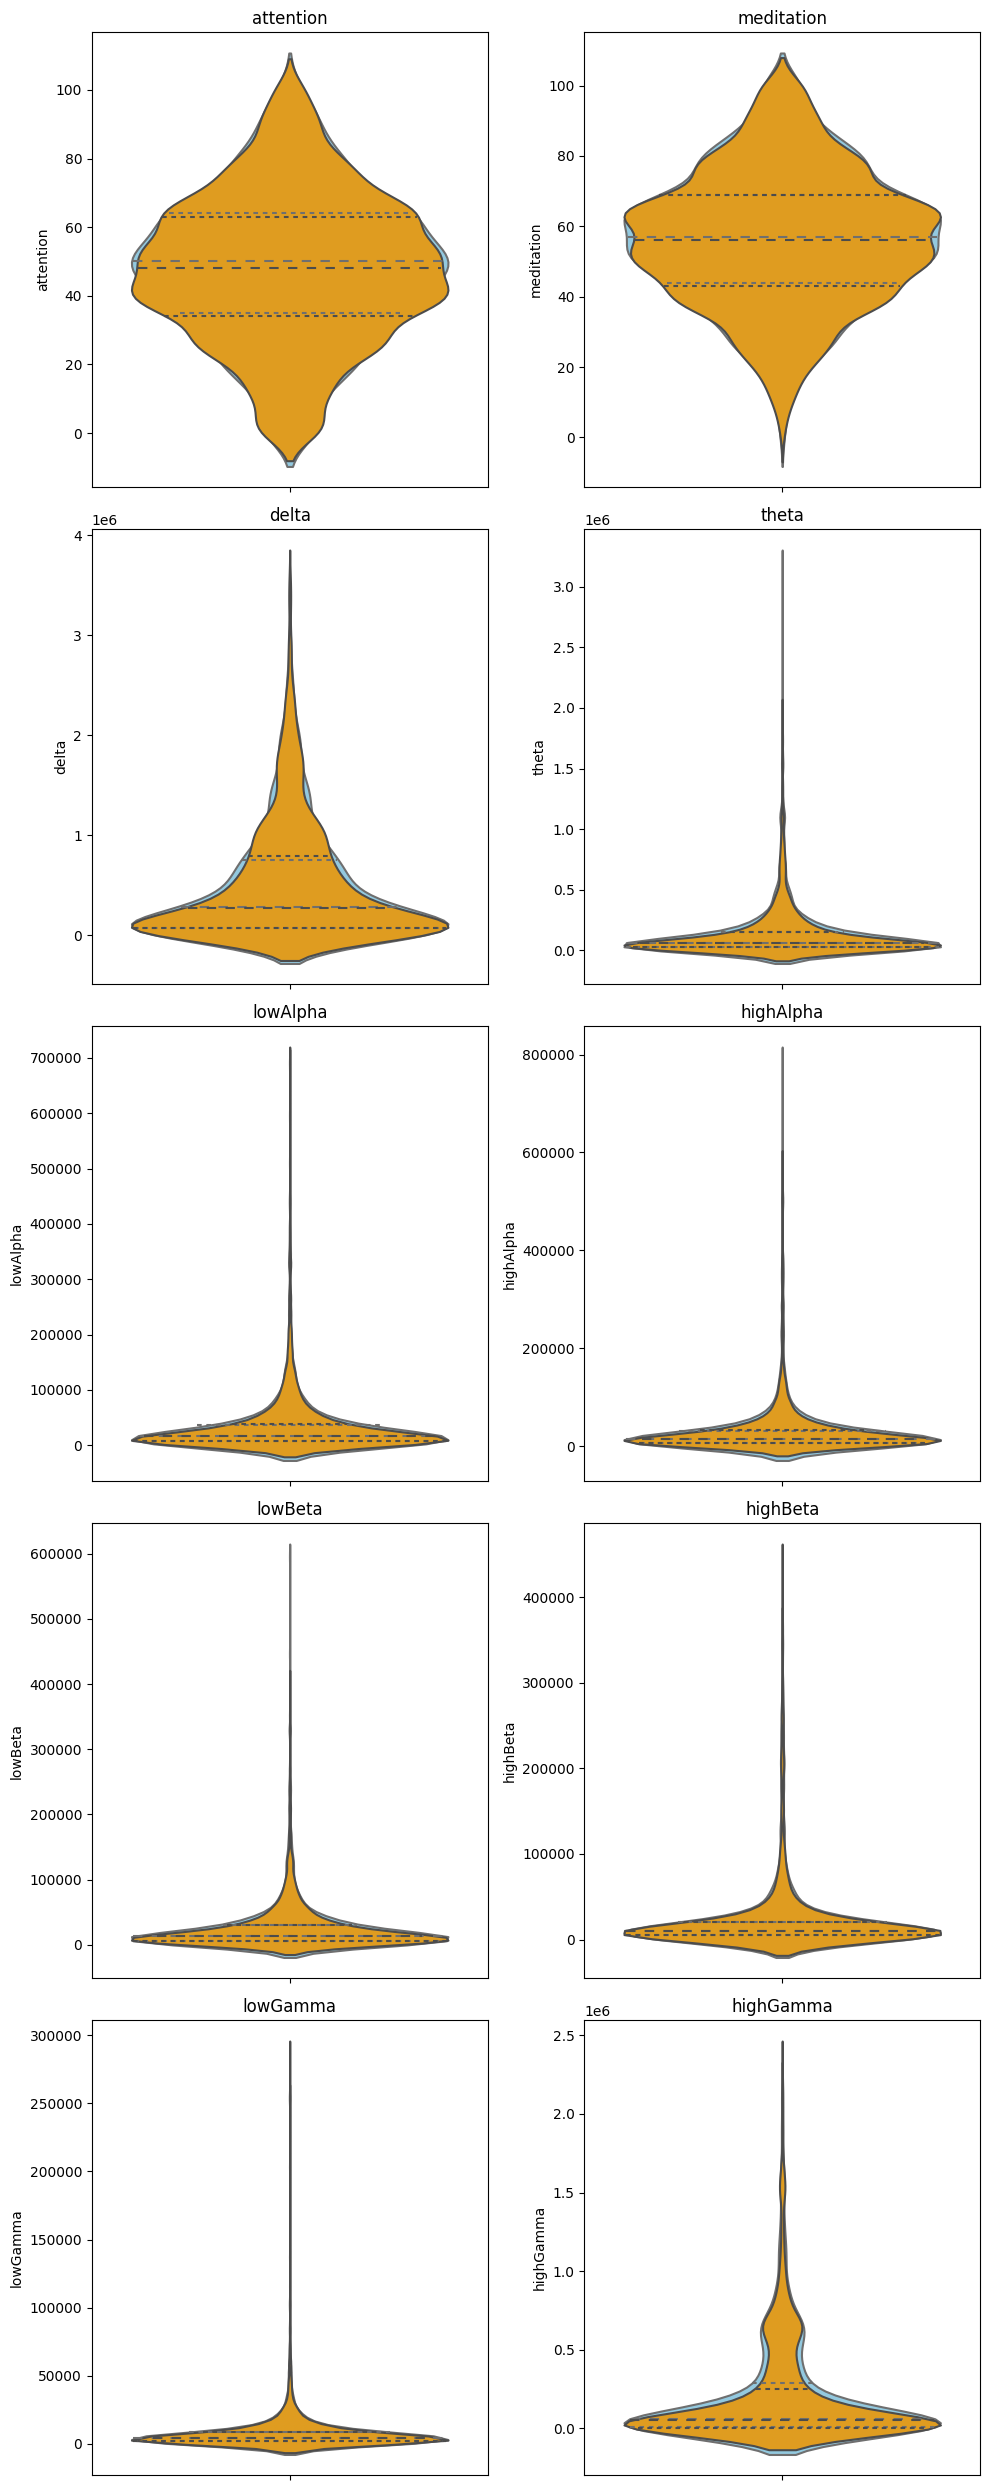

In [39]:
import numpy as np  # Import NumPy for calculations

# Calculate the number of rows needed based on the number of columns
num_cols = len(X_test.columns)
num_plots_per_row = 2
num_rows = int(np.ceil(num_cols / num_plots_per_row))

# Adjust the figure size based on the number of rows and plots per row
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(10, 5 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(X_test.columns):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    ax = axes[row_idx, col_idx]
    
    sns.violinplot(y=X_test[column], color='skyblue', inner='quartile', ax=ax)
    sns.violinplot(y=X_train[column], color='orange', inner='quartile', ax=ax)
    ax.set_title(column)

# Remove empty subplots
for i in range(num_cols, num_rows * num_plots_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


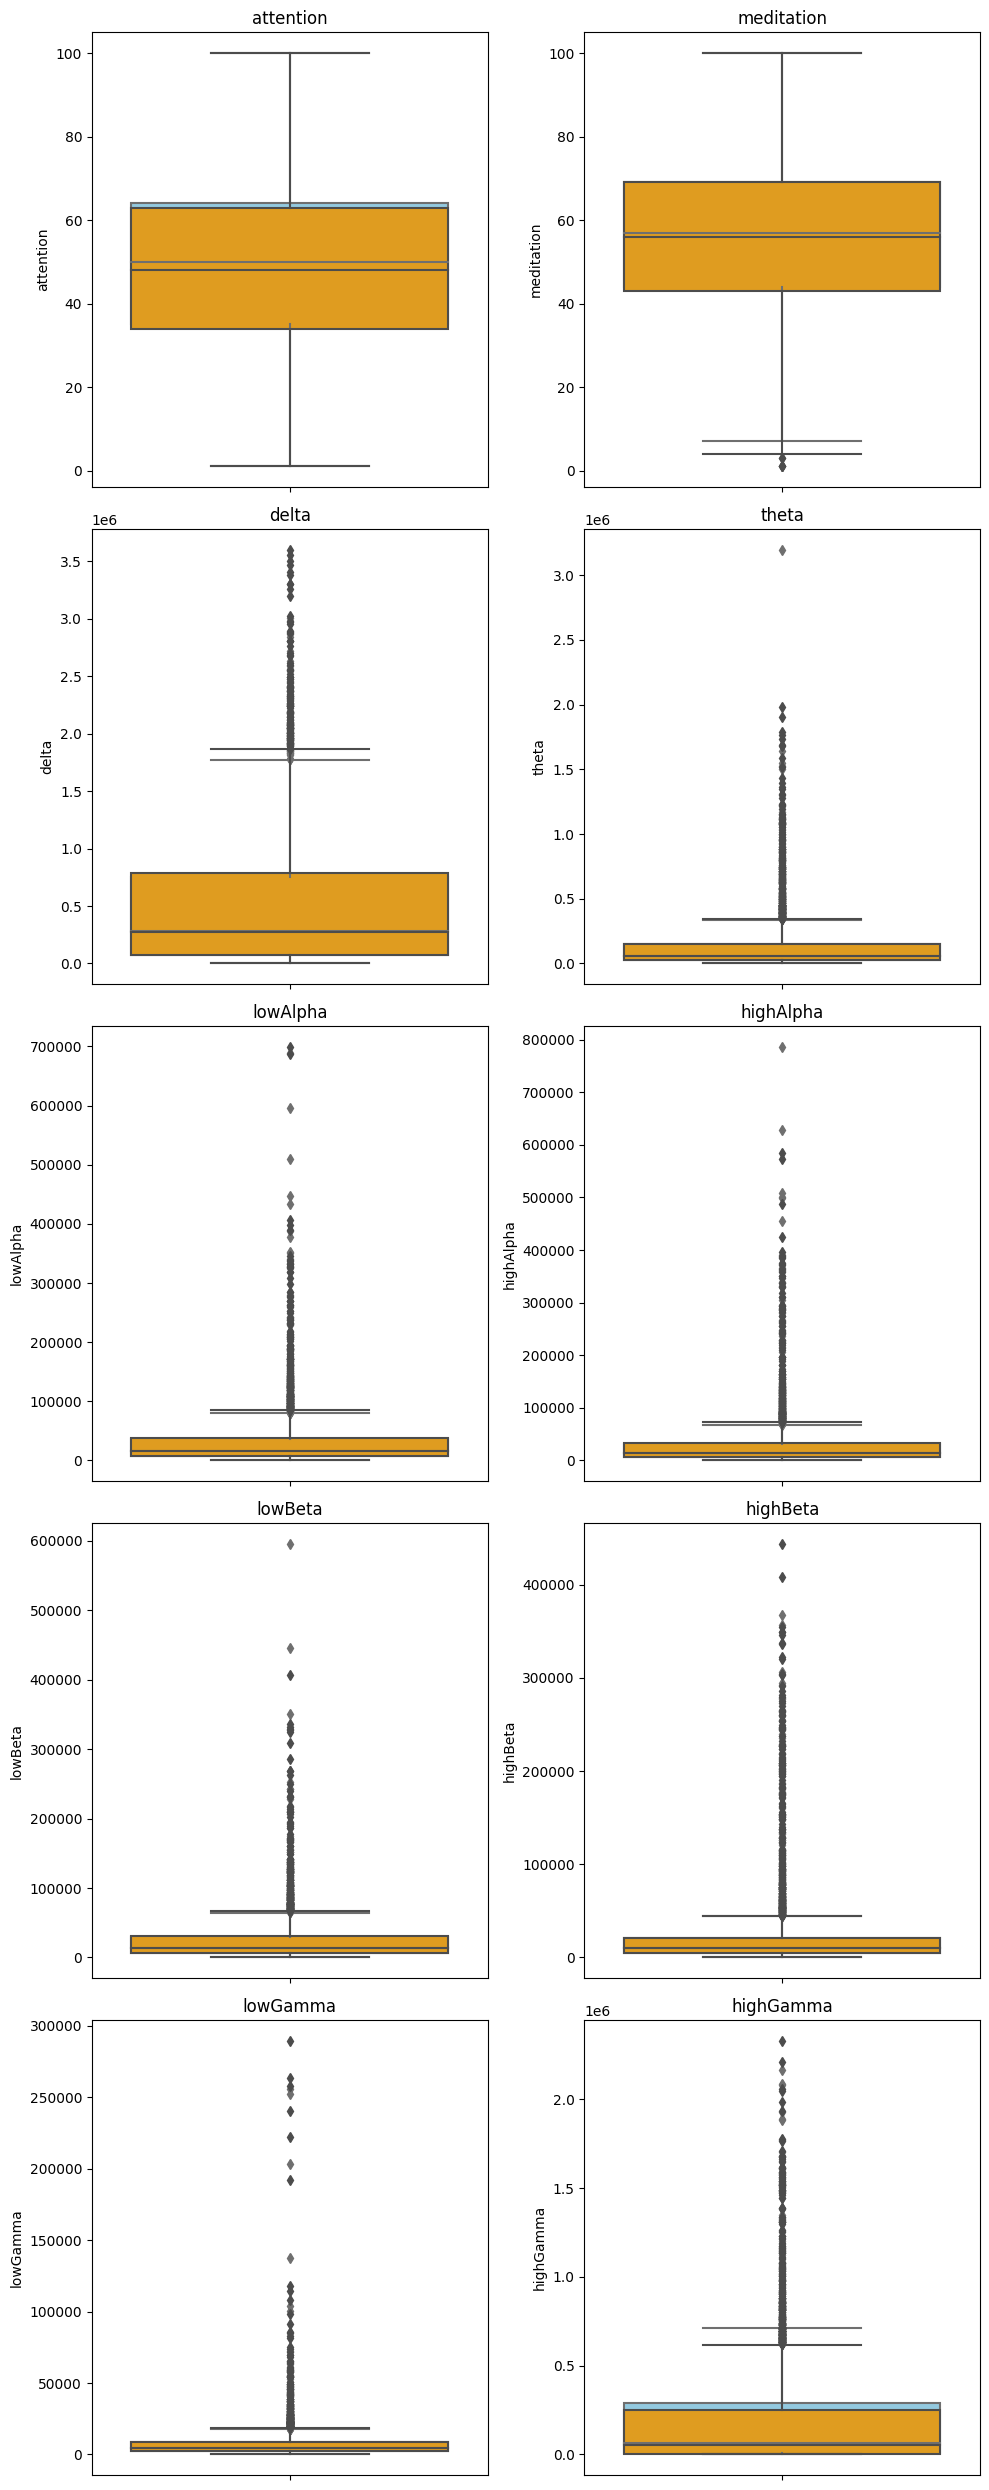

In [43]:
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of rows needed based on the number of columns
num_cols = len(X_test.columns)
num_plots_per_row = 2
num_rows = int(np.ceil(num_cols / num_plots_per_row))

# Adjust the figure size based on the number of rows and plots per row
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(10, 5 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(X_test.columns):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    ax = axes[row_idx, col_idx]
    
    sns.boxplot(y=X_test[column], color='skyblue', ax=ax)
    sns.boxplot(y=X_train[column], color='orange', ax=ax)
    ax.set_title(column)

# Remove empty subplots
for i in range(num_cols, num_rows * num_plots_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


This indicates there is not a lot of difference in the datapoints in the train and test sets which is actually good because we will be able to train a good modl

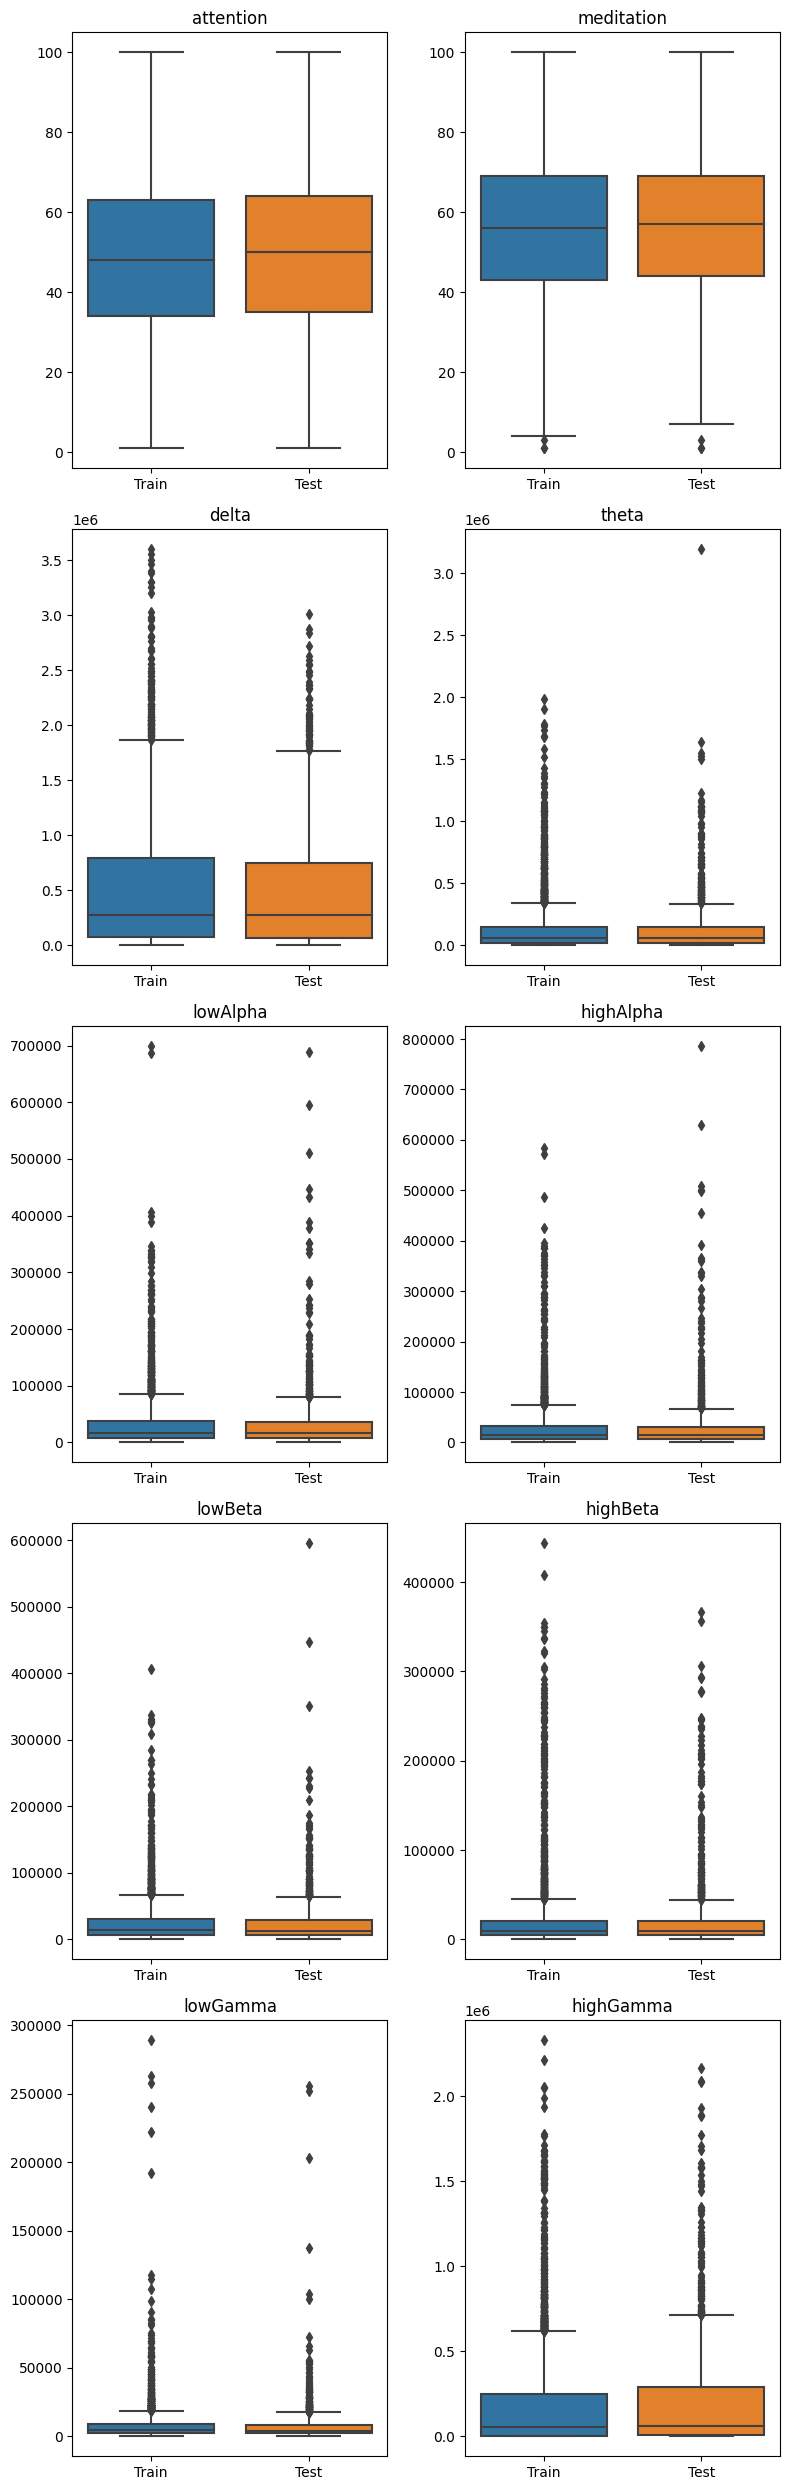

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of rows needed based on the number of columns
num_cols = len(X_test.columns)
num_plots_per_row = 2
num_rows = int(np.ceil(num_cols / num_plots_per_row))

# Adjust the figure size based on the number of rows and plots per row
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(8, 5 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(X_test.columns):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row

    # Create a single axis for each variable
    ax = axes[row_idx, col_idx]

    # Create boxplots for train and test data side by side
    sns.boxplot(data=[X_train[column], X_test[column]], ax=ax)
    ax.set_title(column)
    ax.set_xticklabels(['Train', 'Test'])

plt.tight_layout()
plt.show()


Now lets plot when sleepiness=0 on the left while sleepiness=1 on the right

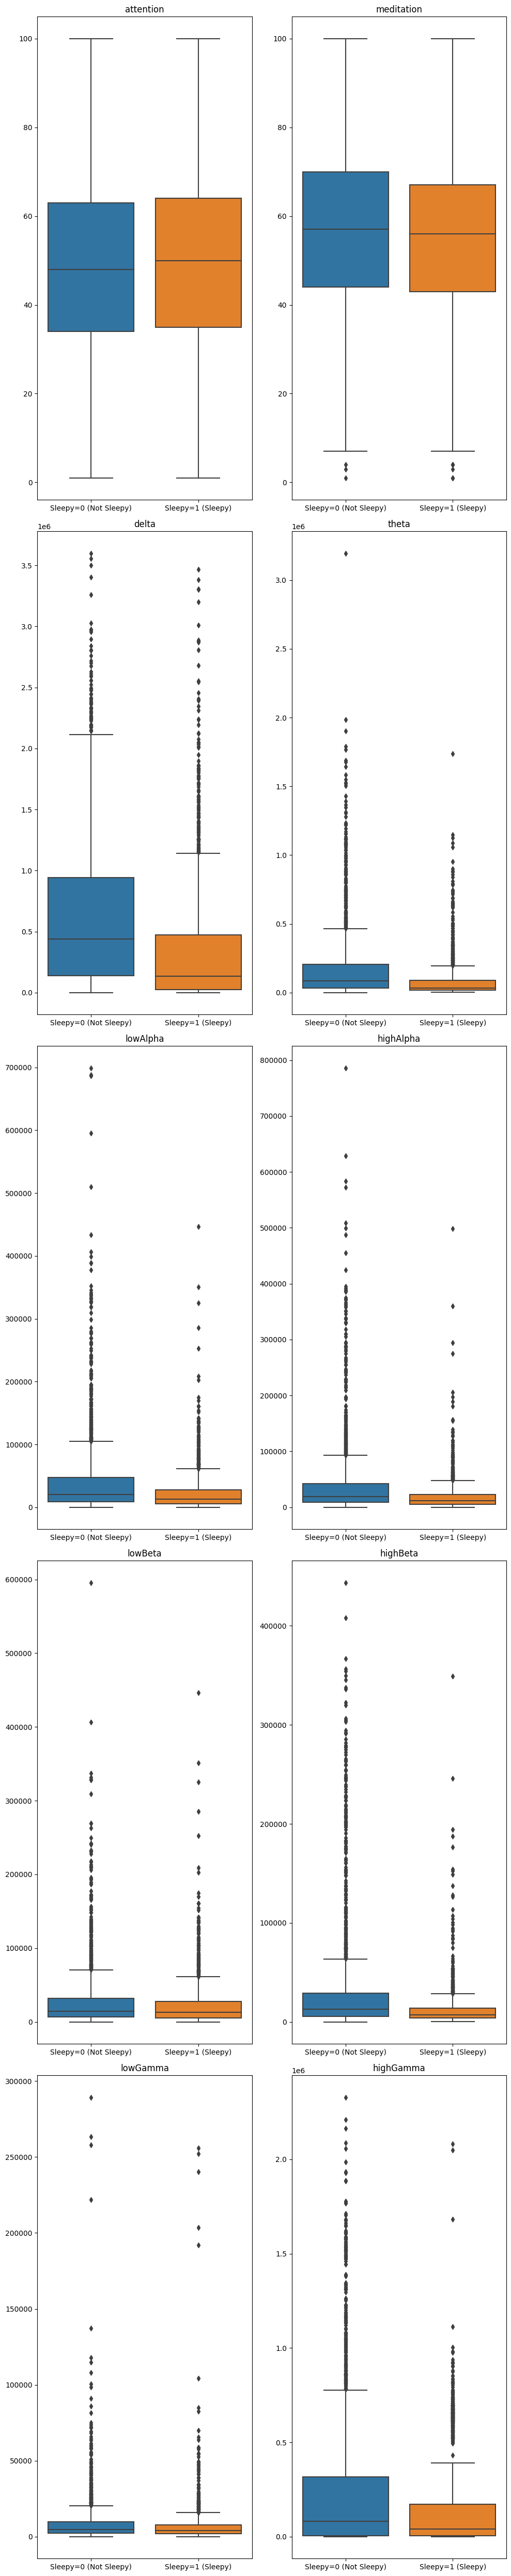

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame for each class of sleepiness
df_sleepy_0 = df[df['sleepiness'] == 0]
df_sleepy_1 = df[df['sleepiness'] == 1]

# # Calculate the number of columns needed based on the number of features
# num_cols = df_sleepy_0.shape[1]

# # Define the number of plots per row (2 plots: sleepiness 0 and sleepiness 1)
# num_plots_per_row = 2

# # Calculate the number of rows needed based on the number of columns and plots per row
# num_rows = int(np.ceil(num_cols / num_plots_per_row))

# # Adjust the figure size based on the number of rows and plots per row
# fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(12, 5 * num_rows))

# # Flatten the axes if there's only one row
# if num_rows == 1:
#     axes = axes.reshape(1, -1)

# # Loop through each feature and create violin plots
# for i, column in enumerate(df_sleepy_0.columns):
#     row_idx = i // num_plots_per_row
#     col_idx = i % num_plots_per_row
    
#     # Create a violin plot for sleepiness 0 on the left
#     ax_left = axes[row_idx, 0]
#     sns.violinplot(y=df_sleepy_0[column], color='skyblue', inner='quartile', ax=ax_left)
#     ax_left.set_title(f"{column} (Sleepiness 0)")

#     # Create a violin plot for sleepiness 1 on the right
#     ax_right = axes[row_idx, 1]
#     sns.violinplot(y=df_sleepy_1[column], color='orange', inner='quartile', ax=ax_right)
#     ax_right.set_title(f"{column} (Sleepiness 1)")

# # Remove empty subplots
#  for i in range(num_cols, num_rows * num_plots_per_row):
#     fig.delaxes(axes.flatten()[i])

# plt.tight_layout()
# plt.show()




# -----

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of rows needed based on the number of columns
num_cols = len(df.columns)
num_plots_per_row = 2
# num_rows = int(np.ceil(num_cols / num_plots_per_row))
num_rows = 5

# Adjust the figure size based on the number of rows and plots per row
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(10, 10 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(X_test.columns):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row

    # Create a single axis for each variable
    ax = axes[row_idx, col_idx]

    # Create boxplots for train and test data side by side
    sns.boxplot(data=[df_sleepy_0[column], df_sleepy_1[column]], ax=ax)
    ax.set_title(column)
    ax.set_xticklabels(['Sleepy=0 (Not Sleepy)', 'Sleepy=1 (Sleepy)'])

plt.tight_layout()
plt.show()


# Pycaret:

In [28]:
!pip install pycaret -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [30]:
import pycaret.anomaly as anm
import pycaret.classification as cl
import pandas as pd

In [31]:
data = pd.read_csv('/kaggle/input/sleepy-driver-eeg-brainwave-data/acquiredDataset.csv')
data.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


sort all data

In [32]:
dfsample = data.sample(frac=1)
dfsample

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
1900,47,48,113377,5616,947,861,947,394,67,12744,1
898,38,44,1330903,370088,23815,89086,23815,16153,57873,6705,1
2380,48,100,7067,23312,18800,24155,18800,6014,3705,132633,1
3340,43,47,423560,354840,54839,118530,54839,13841,12216,67519,0
1681,7,51,917037,330728,72795,12165,25351,9622,3873,362277,0
...,...,...,...,...,...,...,...,...,...,...,...
2551,44,70,6785,9103,9298,3092,9298,6652,2204,76224,1
3392,64,51,705204,264410,51566,21753,51566,14909,22585,72666,0
3027,54,40,894348,112117,14005,3538,14005,3826,2478,175456,0
2071,67,43,2311030,299619,32789,17245,32789,12497,5355,615326,1


Try changing the size test to 30%

In [33]:
sizetest = 500
dfTrain = dfsample[:-sizetest]
dfTest = dfsample[-sizetest:]

In [34]:
an = anm.setup(dfTrain)
model = anm.create_model('histogram')
preds = anm.assign_model(model)
preds = preds.drop('Anomaly',axis=1)
preds

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c0e24b85000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /opt/conda/lib/python3.10/site-packages/scipy.libs/libopenblasp-r0-23e5df77.3.21.dev.so: can

,Description,Value
0,Session id,5796
1,Original data shape,"(3235, 11)"
2,Transformed data shape,"(3235, 11)"
3,Numeric features,11
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
1900,47,48,113377,5616,947,861,947,394,67,12744,1,30.610630
898,38,44,1330903,370088,23815,89086,23815,16153,57873,6705,1,30.671704
2380,48,100,7067,23312,18800,24155,18800,6014,3705,132633,1,30.774423
3340,43,47,423560,354840,54839,118530,54839,13841,12216,67519,0,30.219333
1681,7,51,917037,330728,72795,12165,25351,9622,3873,362277,0,30.356217
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,26,35,460589,42965,11282,9499,11282,1572,1672,191112,1,30.773153
2798,66,44,10377,19445,13424,3367,13424,8980,2580,18779,1,30.639141
1293,10,100,1869340,126246,94824,40753,8538,6503,6775,190749,0,30.550801
1703,64,75,434312,398544,66320,51856,39158,80809,32141,408151,0,30.339887


In [35]:
classif = cl.setup(preds,target='classification',normalize=True, normalize_method='minmax',fold=9)
top3 = classif.compare_models(n_select=3, fold=9,include=['ada','gbc','et'],turbo=True)
preds


,Description,Value
0,Session id,7147
1,Target,classification
2,Target type,Binary
3,Original data shape,"(3235, 12)"
4,Transformed data shape,"(3235, 12)"
5,Transformed train set shape,"(2264, 12)"
6,Transformed test set shape,"(971, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9996,1.0000,1.0000,0.9990,0.9995,0.9991,0.9991,0.3367
gbc,Gradient Boosting Classifier,0.9996,1.0000,1.0000,0.9990,0.9995,0.9991,0.9991,0.5978
et,Extra Trees Classifier,0.9991,1.0000,0.9980,1.0000,0.9990,0.9982,0.9982,0.3100


Processing:   0%|          | 0/19 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
1900,47,48,113377,5616,947,861,947,394,67,12744,1,30.610630
898,38,44,1330903,370088,23815,89086,23815,16153,57873,6705,1,30.671704
2380,48,100,7067,23312,18800,24155,18800,6014,3705,132633,1,30.774423
3340,43,47,423560,354840,54839,118530,54839,13841,12216,67519,0,30.219333
1681,7,51,917037,330728,72795,12165,25351,9622,3873,362277,0,30.356217
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,26,35,460589,42965,11282,9499,11282,1572,1672,191112,1,30.773153
2798,66,44,10377,19445,13424,3367,13424,8980,2580,18779,1,30.639141
1293,10,100,1869340,126246,94824,40753,8538,6503,6775,190749,0,30.550801
1703,64,75,434312,398544,66320,51856,39158,80809,32141,408151,0,30.339887


In [36]:
an = anm.setup(dfTest)
model = anm.create_model('histogram')
dfTestsAnom  = anm.assign_model(model)
dfTestsAnom  = dfTestsAnom.drop('Anomaly',axis=1)
dfTestsAnom

,Description,Value
0,Session id,3375
1,Original data shape,"(500, 11)"
2,Transformed data shape,"(500, 11)"
3,Numeric features,11
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
3396,47,67,171238,108588,48871,101225,48871,36248,12650,99941,0,30.119985
3610,60,56,220271,57972,10033,70305,10033,15577,13055,5246,0,30.141629
1812,16,47,537678,26433,687,1111,687,1313,995,59074,1,30.845929
44,30,56,70844,125880,13773,8511,13773,4022,1452,1172,0,30.181150
1956,17,30,832781,122448,1250,4994,1250,2950,7140,175632,1,30.976699
...,...,...,...,...,...,...,...,...,...,...,...,...
2551,44,70,6785,9103,9298,3092,9298,6652,2204,76224,1,30.632911
3392,64,51,705204,264410,51566,21753,51566,14909,22585,72666,0,30.129670
3027,54,40,894348,112117,14005,3538,14005,3826,2478,175456,0,30.253392
2071,67,43,2311030,299619,32789,17245,32789,12497,5355,615326,1,30.694593


In [37]:
finalpreds = classif.predict_model(top3[0],dfTestsAnom)
finalpreds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,Anomaly_Score,classification,prediction_label,prediction_score
3396,47,67,171238,108588,48871,101225,48871,36248,12650,99941,30.119986,0,0,0.9952
3610,60,56,220271,57972,10033,70305,10033,15577,13055,5246,30.141630,0,0,0.9952
1812,16,47,537678,26433,687,1111,687,1313,995,59074,30.845928,1,1,0.9935
44,30,56,70844,125880,13773,8511,13773,4022,1452,1172,30.181150,0,0,1.0000
1956,17,30,832781,122448,1250,4994,1250,2950,7140,175632,30.976700,1,1,0.9935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,44,70,6785,9103,9298,3092,9298,6652,2204,76224,30.632912,1,1,1.0000
3392,64,51,705204,264410,51566,21753,51566,14909,22585,72666,30.129669,0,0,0.9952
3027,54,40,894348,112117,14005,3538,14005,3826,2478,175456,30.253391,0,0,0.9952
2071,67,43,2311030,299619,32789,17245,32789,12497,5355,615326,30.694593,1,1,1.0000


In [38]:
from sklearn.metrics import confusion_matrix,accuracy_score
acc = accuracy_score(list(finalpreds['classification'].values),list(finalpreds['prediction_label'].astype('int').values))
cfm = confusion_matrix(list(finalpreds['classification'].values),list(finalpreds['prediction_label'].astype('int').values))
print("Conf. Matrix\n",cfm,"\n")
print("Accuracy: ",acc*100,"%")

Conf. Matrix
 [[295   0]
 [  0 205]] 

Accuracy:  100.0 %


In [39]:
X.shape

(3735, 10)

In [43]:
30/100*X.shape[0]

1120.5

Now lets take the same size

In [65]:
sizetest = 1000
dfTrain = dfsample[:-sizetest]
dfTest = dfsample[-sizetest:]

In [66]:
an = anm.setup(dfTrain)
model = anm.create_model('histogram')
preds = anm.assign_model(model)
preds = preds.drop('Anomaly',axis=1)
preds

,Description,Value
0,Session id,581
1,Original data shape,"(2735, 11)"
2,Transformed data shape,"(2735, 11)"
3,Numeric features,11
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
1900,47,48,113377,5616,947,861,947,394,67,12744,1,30.620217
898,38,44,1330903,370088,23815,89086,23815,16153,57873,6705,1,30.686726
2380,48,100,7067,23312,18800,24155,18800,6014,3705,132633,1,30.788232
3340,43,47,423560,354840,54839,118530,54839,13841,12216,67519,0,30.196688
1681,7,51,917037,330728,72795,12165,25351,9622,3873,362277,0,30.346564
...,...,...,...,...,...,...,...,...,...,...,...,...
397,54,38,1085634,59669,9146,23763,9146,7115,4416,4158,0,30.316556
3213,51,70,918601,59738,35181,49183,35181,17285,11144,329829,0,30.151570
1423,16,54,770855,225298,25654,34802,9461,12283,13503,173109,0,30.335695
1980,50,63,506788,87134,40361,7193,40361,4692,1635,174544,1,30.551027


In [67]:
classif = cl.setup(preds,target='classification',normalize=True, normalize_method='minmax',fold=9)
top3 = classif.compare_models(n_select=3, fold=9,include=['ada','gbc','et'],turbo=True)
preds


,Description,Value
0,Session id,5904
1,Target,classification
2,Target type,Binary
3,Original data shape,"(2735, 12)"
4,Transformed data shape,"(2735, 12)"
5,Transformed train set shape,"(1914, 12)"
6,Transformed test set shape,"(821, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9995,1.0000,1.0000,0.9988,0.9994,0.9989,0.9989,0.2933
et,Extra Trees Classifier,0.9995,1.0000,0.9988,1.0000,0.9994,0.9989,0.9989,0.2767
gbc,Gradient Boosting Classifier,0.9979,0.9991,0.9988,0.9964,0.9976,0.9957,0.9957,0.4400


Processing:   0%|          | 0/19 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
1900,47,48,113377,5616,947,861,947,394,67,12744,1,30.620217
898,38,44,1330903,370088,23815,89086,23815,16153,57873,6705,1,30.686726
2380,48,100,7067,23312,18800,24155,18800,6014,3705,132633,1,30.788232
3340,43,47,423560,354840,54839,118530,54839,13841,12216,67519,0,30.196688
1681,7,51,917037,330728,72795,12165,25351,9622,3873,362277,0,30.346564
...,...,...,...,...,...,...,...,...,...,...,...,...
397,54,38,1085634,59669,9146,23763,9146,7115,4416,4158,0,30.316556
3213,51,70,918601,59738,35181,49183,35181,17285,11144,329829,0,30.151570
1423,16,54,770855,225298,25654,34802,9461,12283,13503,173109,0,30.335695
1980,50,63,506788,87134,40361,7193,40361,4692,1635,174544,1,30.551027


In [71]:
an = anm.setup(dfTest)
model = anm.create_model('histogram')
dfTestsAnom  = anm.assign_model(model)
dfTestsAnom  = dfTestsAnom.drop('Anomaly',axis=1)
dfTestsAnom

,Description,Value
0,Session id,1935
1,Original data shape,"(1000, 11)"
2,Transformed data shape,"(1000, 11)"
3,Numeric features,11
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification,Anomaly_Score
3651,51,53,1571338,158578,5305,42613,5305,28491,6151,6104,0,30.197734
2921,43,54,2051784,695351,137463,129175,137463,74673,114704,961435,0,30.206701
1179,21,81,709275,40275,35248,25293,10471,6823,11286,908118,0,30.426843
1828,13,61,222877,33871,19742,3832,19742,2990,1565,64045,1,30.694366
1144,30,90,1889060,469668,69575,42947,36156,23354,4025,470835,0,30.427091
...,...,...,...,...,...,...,...,...,...,...,...,...
2551,44,70,6785,9103,9298,3092,9298,6652,2204,76224,1,30.549976
3392,64,51,705204,264410,51566,21753,51566,14909,22585,72666,0,30.200270
3027,54,40,894348,112117,14005,3538,14005,3826,2478,175456,0,30.305670
2071,67,43,2311030,299619,32789,17245,32789,12497,5355,615326,1,30.619801


In [73]:
top3

[AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                    estimator=None, learning_rate=1.0, n_estimators=50,
                    random_state=5904),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=5904, verbose=0, warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                          

In [78]:
finalpreds0 = classif.predict_model(top3[0],dfTestsAnom)
finalpreds0
finalpreds1 = classif.predict_model(top3[1],dfTestsAnom)
finalpreds1
finalpreds2 = classif.predict_model(top3[2],dfTestsAnom)
finalpreds2

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.9450,0.9865,0.9060,0.9658,0.9349,0.8874,0.8887


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9970,1.0000,0.9977,0.9954,0.9966,0.9939,0.9939


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9470,0.9423,0.9060,0.9705,0.9371,0.8914,0.8930


,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,Anomaly_Score,classification,prediction_label,prediction_score
3651,51,53,1571338,158578,5305,42613,5305,28491,6151,6104,30.197735,0,0,1.0
2921,43,54,2051784,695351,137463,129175,137463,74673,114704,961435,30.206701,0,0,1.0
1179,21,81,709275,40275,35248,25293,10471,6823,11286,908118,30.426844,0,0,1.0
1828,13,61,222877,33871,19742,3832,19742,2990,1565,64045,30.694366,1,1,1.0
1144,30,90,1889060,469668,69575,42947,36156,23354,4025,470835,30.427092,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,44,70,6785,9103,9298,3092,9298,6652,2204,76224,30.549976,1,1,1.0
3392,64,51,705204,264410,51566,21753,51566,14909,22585,72666,30.200270,0,0,1.0
3027,54,40,894348,112117,14005,3538,14005,3826,2478,175456,30.305670,0,0,1.0
2071,67,43,2311030,299619,32789,17245,32789,12497,5355,615326,30.619801,1,1,1.0


In [79]:
from sklearn.metrics import confusion_matrix,accuracy_score
acc = accuracy_score(list(finalpreds1['classification'].values),list(finalpreds1['prediction_label'].astype('int').values))
cfm = confusion_matrix(list(finalpreds1['classification'].values),list(finalpreds1['prediction_label'].astype('int').values))
print("Conf. Matrix\n",cfm,"\n")
print("Accuracy: ",acc*100,"%")

Conf. Matrix
 [[562   2]
 [  1 435]] 

Accuracy:  99.7 %


Extra trees classifier gives the best results with 70% train data